Adapted from [ner_with_bilstm_and_crf](https://www.kaggle.com/nikkisharma536/ner-with-bilstm-and-crf/notebook)
Altigran Soares da Silva
IComp/UFAM - 15/03/2021


In [ ]:
# For this to work, use:
# Keras 2.3.1
# Also remember to use GPU in your colab notebook
%tensorflow_version 2.x

# Code to read csv file into Colaboratory:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from math import nan
from future.utils import iteritems
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import json
import pickle
import time
from requests import get

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader

!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer

!pip install seqeval
from seqeval.metrics import f1_score, classification_report

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 13.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 14.6 MB/s 
     |████████████████████████████████| 6.6 MB 79.8 MB/s 
     |████████████████████████████████| 120 kB 83.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.9 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=67b0525cc6ea0c77467b2188536e964ddc6c6cd2280da72fa3bd714ca5bc80f5
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [ ]:
# Code to read csv file from google drive into Colaboratory:
DATA_TRAINING_FILE_ID = '1hIe1NaUcYENwTFrG_z1WUEiEkEzhtzbx'
DATA_TRAINING_FILENAME = 'ner_training_dataset.csv'
DATA_DEV_FILE_ID = '1fbR_cCVnnvMiJuaS7tvGE8nHHepciFuG'
DATA_DEV_FILENAME = 'ner_validation_dataset.csv'
DATA_TEST_FILE_ID = '1cz6lxw3dd-zeoKtLewT7pjSkIIh4BjOe'
DATA_TEST_FILENAME = 'ner_test_dataset.csv'
BACKUP_FOLDER_ID = '1W3P_xzWN4P3YTFvHqw0wY-PUClLXne1K'

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded_training = drive.CreateFile({'id': DATA_TRAINING_FILE_ID})
downloaded_training.GetContentFile(DATA_TRAINING_FILENAME)
downloaded_dev = drive.CreateFile({'id': DATA_DEV_FILE_ID})
downloaded_dev.GetContentFile(DATA_DEV_FILENAME)
downloaded_test = drive.CreateFile({'id': DATA_TEST_FILE_ID})
downloaded_test.GetContentFile(DATA_TEST_FILENAME)

# Read the csv file in a dataframe called "data"
training_data = pd.read_csv(DATA_TRAINING_FILENAME, encoding="utf-8")
dev_data = pd.read_csv(DATA_DEV_FILENAME, encoding="utf-8")
test_data = pd.read_csv(DATA_TEST_FILENAME, encoding="utf-8")
# Fill NaN values using the specified method
# Ffill propagate last valid observation/value forward to next valid 
training_data = training_data.fillna(method="ffill")
dev_data = dev_data.fillna(method="ffill")
test_data = test_data.fillna(method="ffill")

notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

In [ ]:
# Explore the input dataset
print("Number of training sentences: ", len(training_data.groupby(['Sentence #'])))
print("Number of dev sentences: ", len(dev_data.groupby(['Sentence #'])))
print("Number of test sentences: ", len(test_data.groupby(['Sentence #'])))

training_words = list(set(training_data["Word"].values))
n_training_words = len(training_words)
print("Number of words in the training dataset: ", n_training_words)
dev_words = list(set(dev_data["Word"].values))
n_dev_words = len(dev_words)
print("Number of words in the dev dataset: ", n_dev_words)
test_words = list(set(test_data["Word"].values))
n_test_words = len(test_words)
print("Number of words in the test dataset: ", n_test_words)

training_tags = list(set(training_data["Tag"].values))
print("Tags in the training dataset:", training_tags)
n_training_tags = len(training_tags)
print("Number of Labels in the training dataset: ", n_training_tags)
dev_tags = list(set(dev_data["Tag"].values))
print("Tags in the dev dataset:", dev_tags)
n_dev_tags = len(dev_tags)
print("Number of Labels in the dev dataset: ", n_dev_tags)
test_tags = list(set(test_data["Tag"].values))
print("Tags in the test dataset:", test_tags)
n_test_tags = len(test_tags)
print("Number of Labels in the test dataset: ", n_test_tags)

print("What the training dataset looks like:")
# Show the first 10 rows
training_data.head(n=10)

Number of training sentences:  226
Number of dev sentences:  40
Number of test sentences:  48
Number of words in the training dataset:  5862
Number of words in the dev dataset:  1874
Number of words in the test dataset:  2030
Tags in the training dataset: ['I-AGMT_DATE', 'I-PARTY', 'B-PARTY', 'I-DOC_NAME', 'O', 'B-DOC_NAME', 'B-AGMT_DATE']
Number of Labels in the training dataset:  7
Tags in the dev dataset: ['I-AGMT_DATE', 'I-PARTY', 'B-PARTY', 'I-DOC_NAME', 'O', 'B-DOC_NAME', 'B-AGMT_DATE']
Number of Labels in the dev dataset:  7
Tags in the test dataset: ['I-AGMT_DATE', 'I-PARTY', 'B-PARTY', 'I-DOC_NAME', 'O', 'B-DOC_NAME', 'B-AGMT_DATE']
Number of Labels in the test dataset:  7
What the training dataset looks like:


,Sentence #,Word,Tag
0,Sentence: 1,Exhibit,O
1,Sentence: 1,99.1,O
2,Sentence: 1,JOINT,B-DOC_NAME
3,Sentence: 1,FILING,I-DOC_NAME
4,Sentence: 1,AGREEMENT,I-DOC_NAME
5,Sentence: 1,The,O
6,Sentence: 1,undersigned,O
7,Sentence: 1,hereby,O
8,Sentence: 1,agree,O
9,Sentence: 1,that,O


In [ ]:
# SentenceGetter re-organize "data" as an arry of sentences
# Each sentence is a list of pairs <word,tag> 
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["Word"].values.tolist(),
                                                        s["Tag"].values.tolist())]
        self.grouped = self.dataset.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

training_getter = SentenceGetter(training_data)
training_sentences = training_getter.sentences
dev_getter = SentenceGetter(dev_data)
dev_sentences = dev_getter.sentences
test_getter = SentenceGetter(test_data)
test_sentences = test_getter.sentences

# Example: training sentence #200 
training_sentences[200]

[('Exhibit', 'O'),
 ('10.8', 'O'),
 ('Services', 'B-DOC_NAME'),
 ('Agreement', 'I-DOC_NAME'),
 ('Oaktree', 'B-PARTY'),
 ('Capital', 'I-PARTY'),
 ('Management', 'I-PARTY'),
 (',', 'I-PARTY'),
 ('L.P.', 'I-PARTY'),
 ('and', 'O'),
 ('Oaktree', 'B-PARTY'),
 ('Capital', 'I-PARTY'),
 ('Management', 'I-PARTY'),
 ('(', 'I-PARTY'),
 ('International', 'I-PARTY'),
 (')', 'I-PARTY'),
 ('Limited', 'I-PARTY'),
 ('September', 'O'),
 ('2018', 'O'),
 ('1', 'O'),
 ('THIS', 'O'),
 ('SERVICES', 'B-DOC_NAME'),
 ('AGREEMENT', 'I-DOC_NAME'),
 ('(', 'O'),
 ('this', 'O'),
 ('“', 'O'),
 ('Agreement', 'O'),
 ('”', 'O'),
 (')', 'O'),
 ('is', 'O'),
 ('made', 'O'),
 ('on', 'O'),
 ('25', 'B-AGMT_DATE'),
 ('September', 'I-AGMT_DATE'),
 ('2018', 'I-AGMT_DATE'),
 ('BETWEEN', 'O'),
 (':', 'O'),
 ('(', 'O'),
 ('1', 'O'),
 (')', 'O'),
 ('Oaktree', 'B-PARTY'),
 ('Capital', 'I-PARTY'),
 ('Management', 'I-PARTY'),
 (',', 'I-PARTY'),
 ('L.P.', 'I-PARTY'),
 ('a', 'O'),
 ('Delaware', 'O'),
 ('limited', 'O'),
 ('partnership', 'O

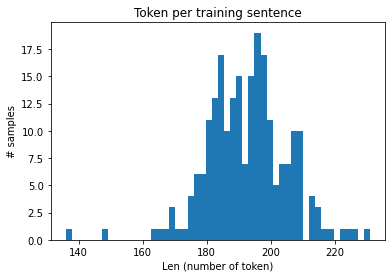

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in training_sentences], bins=50)
plt.title('Token per training sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

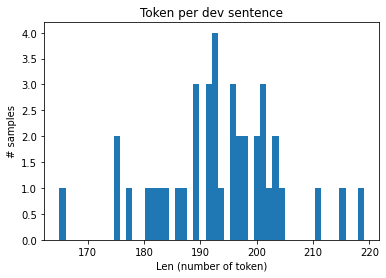

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in dev_sentences], bins=50)
plt.title('Token per dev sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

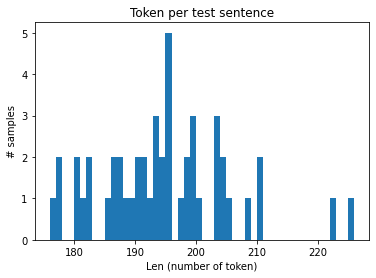

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in test_sentences], bins=50)
plt.title('Token per test sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [ ]:
# Keras (and most other ML packages) expect all the ids to be numeric, 
# this is an optimisation to save memory. 
# We will create the following dictionaries:
# word2idx: assign a numeric index to each word in the dataset
# idx2word: inverted version of word2idx
# tag2idx: assign a numeric index to each tag in the dataset
# idx2tag: inverted version of tag2idx

# Group training, dev and test data in order to create word-index dicts and to
# convert data to numeric indeces later
data = pd.concat([training_data, dev_data, test_data])

# words <= list of all words in the input dataset
words = list(set(data["Word"].values))
n_words = len(words)

# tags <= list of all tags in the input dataset
tags = []
for tag in set(data["Tag"].values):
    if tag is nan or isinstance(tag, float):
        tags.append('unk')
    else:
        tags.append(tag)
n_tags = len(tags)

# Dictionaries
word2idx = {w: i for i, w in enumerate(words)}
idx2word = {i: w for w, i in iteritems(word2idx)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}

# Index number for the word 'business'
print(word2idx['business'])
# Word of index 10
print(idx2word[10])
# Index number for the tag 'B-PARTY'
print(tag2idx['B-PARTY'])
# Tag of index 2
print(idx2tag[2])

2926
BIOCEPT
2
B-PARTY


In [ ]:
# Convert train, dev and test data to numeric values
X_train = [[word2idx[w[0]] for w in s] for s in training_sentences]
y_train = [[tag2idx[w[1]] for w in s] for s in training_sentences]

X_dev = [[word2idx[w[0]] for w in s] for s in dev_sentences]
y_dev = [[tag2idx[w[1]] for w in s] for s in dev_sentences]

X_test = [[word2idx[w[0]] for w in s] for s in test_sentences]
y_test = [[tag2idx[w[1]] for w in s] for s in test_sentences]

In [ ]:
# Use this function to randomly remove some points from training dataset
# Use removal percentage in decimal value. E.g.: if you set as 0.5, it will
# remove 50% of the dataset

def random_remove_data_points(dataset, labels, removal_percentage):
    if removal_percentage < 0 or removal_percentage > 1:
        raise Exception("Invalid removal percentage")
    
    if removal_percentage == 1:
        raise Exception("You can't remove the entire dataset")
    
    number_of_points_remaining = round(len(dataset)*(1-removal_percentage))

    try_again = True

    while try_again:
      random_idxs = np.random.choice(len(dataset), number_of_points_remaining, replace=False)
      cut_dataset_sentences = [dataset[i] for i in random_idxs]
      cut_dataset_labels = [labels[i] for i in random_idxs]
      cut_tags = list(set([idx2tag[j] for sub in cut_dataset_labels for j in sub]))

      if all(i in cut_tags for i in tags if i[:2] == "B-"):
        try_again = False

    return cut_dataset_sentences, cut_dataset_labels 

print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")
# X_train, y_train = random_remove_data_points(X_train, y_train, 0.95)
print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")

Points in X_train before removal: 226
Points in y_train before removal: 226
Points in X_train before removal: 226
Points in y_train before removal: 226


In [ ]:
# Aux functions to save data and dicts, if data consistency is important
# and there is desire to not random split again

def save_backup_dataset(dataset, filename):
  dataset_df = pd.DataFrame(dataset)
  dataset_df.to_csv(filename, index=False)
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

def save_backup_dict(dict, filename):
  dict_file = open(filename, "wb")
  pickle.dump(dict, dict_file)
  dict_file.close()
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

In [ ]:
# Uncomment this cell if you want to save data for further use

# Check some points before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['business'])
print(tag2idx['B-PARTY'])
print(idx2tag[2])
print(idx2word[10])
print(n_words)
print(n_tags)

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

save_backup_dataset(X_train, X_train_filename)
save_backup_dataset(y_train, y_train_filename)
save_backup_dataset(X_dev, X_dev_filename)
save_backup_dataset(y_dev, y_dev_filename)
save_backup_dataset(X_test, X_test_filename)
save_backup_dataset(y_test, y_test_filename)

save_backup_dict(word2idx, word2idx_filename)
save_backup_dict(idx2word, idx2word_filename)
save_backup_dict(tag2idx, tag2idx_filename)
save_backup_dict(idx2tag, idx2tag_filename)

save_backup_dict({"n_words":n_words, "n_tags":n_tags}, others_filename)

NameError: ignored

In [1]:
# Uncomment this cell if you want to load saved data

# Re-import necessary libs
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pickle, math
from requests import get
import numpy as np
import matplotlib.pyplot as plt
import random
import time
%tensorflow_version 2.x
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader
!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer
import matplotlib.pyplot as plt
!pip install seqeval
from seqeval.metrics import f1_score, classification_report

BACKUP_FOLDER_ID = '1W3P_xzWN4P3YTFvHqw0wY-PUClLXne1K'
notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name'].replace("_CWR","")

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

# Re-get important variables
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def get_backup_files_ids(folder_id):
  file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(folder_id)}).GetList()
  return file_list

def load_backup_dataset(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.csv")

  dataset = pd.read_csv(f"{file_id}.csv", encoding="latin1")
  dataset = dataset.values.tolist()
  dataset = [ [ int(word) for word in sentence if str(word) != 'nan' ] for sentence in dataset]
  return dataset

def load_backup_dict(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.pkl")

  dict_file = open(f"{file_id}.pkl", "rb")
  out_dict = pickle.load(dict_file)
  return out_dict

backup_file_list = get_backup_files_ids(BACKUP_FOLDER_ID)

X_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_train_filename][0]['id']
y_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_train_filename][0]['id']
X_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_dev_filename][0]['id']
y_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_dev_filename][0]['id']
X_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_test_filename][0]['id']
y_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_test_filename][0]['id']

word2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == word2idx_filename][0]['id']
idx2word_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2word_filename][0]['id']
tag2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == tag2idx_filename][0]['id']
idx2tag_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2tag_filename][0]['id']

others_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == others_filename][0]['id']

X_train = load_backup_dataset(X_train_file_id)
y_train = load_backup_dataset(y_train_file_id)
X_dev = load_backup_dataset(X_dev_file_id)
y_dev = load_backup_dataset(y_dev_file_id)
X_test = load_backup_dataset(X_test_file_id)
y_test = load_backup_dataset(y_test_file_id)

word2idx = load_backup_dict(word2idx_file_id)
idx2word = load_backup_dict(idx2word_file_id)
tag2idx = load_backup_dict(tag2idx_file_id)
idx2tag = load_backup_dict(idx2tag_file_id)

others = load_backup_dict(others_file_id)

n_words = others["n_words"]
n_tags = others["n_tags"]

# Check some points after loading data to see if they match the ones before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['business'])
print(tag2idx['B-PARTY'])
print(idx2tag[2])
print(idx2word[10])
print(n_words)
print(n_tags)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
[4696, 6573, 1251, 477, 4439, 5724, 3491, 5780, 5261, 6633, 3830, 4730, 6084, 1189, 5114, 6004, 6958, 3362, 3830, 855, 798, 4735, 5114, 3066, 6686, 7039, 99, 6066, 2109, 1777, 417, 6414, 7039, 798, 5724, 6727, 5749, 4987, 7039, 2193, 790, 798, 7137, 3949, 7039, 5587, 7039, 1512, 7039, 6822, 1494, 5113, 2310, 5621, 2655, 5113, 74, 4730, 5342, 3581, 3589, 2652, 6209, 798, 3830, 3491, 4187, 6943, 7039, 5125, 74, 4545, 798, 6209, 798, 3708, 1725, 3362, 6822, 6659, 6181, 6004, 3830, 1184, 798, 6239, 3102, 3581, 1176, 3830, 1148, 2078, 6529, 798, 5283, 7039, 790, 6892, 7190, 4896, 7088, 7039, 14, 5621, 6104, 3581, 5771, 1929, 1899

In [2]:
from transformers import pipeline
from future.utils import iteritems

# Augmentation function using entity replacement technique.
# It will generate a new dataset, with X% more points based on
# the original dataset. E.g.: if you set augmentation percentage as 0.5 and dataset has
# 1000 points, it will generate a dataset with 1500 points.

def generate_sentences(dataset, labels, augmented_set_size_percentage):
    if augmented_set_size_percentage < 0:
        raise Exception("Invalid augmented set size percentage")

    unmasker = pipeline('fill-mask', model='bert-base-multilingual-cased')
    
    number_of_new_sentences = math.ceil(augmented_set_size_percentage * len(dataset))
    random_idxs = np.random.choice(len(dataset), number_of_new_sentences, replace=True)
    
    base_sequences = [dataset[i] for i in random_idxs]
    base_labels = [labels[i] for i in random_idxs]

    new_sequences = []
    new_labels = []
    
    for k, sequence in enumerate(base_sequences):
      sequence_str = [idx2word[word] for word in sequence]
      replaceable_indices = [i for i,label in enumerate(base_labels[k]) if label == tag2idx["O"]]
      replace_percent = round(random.uniform(0.1, 1), 1)
      replace_qty = max(math.floor(replace_percent*len(replaceable_indices)), 1)
      replace_indices = random.sample(replaceable_indices, k=replace_qty)
      replace_indices.sort()

      masked_text_list = ["[MASK]" if i in replace_indices else word for i,word in enumerate(sequence_str)]
      new_mask_sent = ' '.join(masked_text_list)
      augmented_text_list = unmasker(new_mask_sent)

      augmented_sentence = sequence_str.copy()
      if len(replace_indices) == 1:
        augmented_text_list = [augmented_text_list]

      for i,index in enumerate(replace_indices):
        available_words = [word["token_str"] for word in augmented_text_list[i] if word["token_str"] != sequence_str[index]]
        new_word = random.choice(available_words)
        augmented_sentence[index] = new_word

      # print("Original text->",sequence_str)
      # print("Augmented text->",augmented_sentence)

      new_sequences.append(augmented_sentence)
      new_labels.append(base_labels[k])

    all_words = list(set([word for seq in new_sequences for word in seq]))
    updated_word2idx = word2idx.copy()
    updated_idx2word = idx2word.copy()
    for word in all_words:
      try:
        updated_word2idx[word]
      except:
        updated_word2idx[word] = len(updated_word2idx)
    updated_idx2word = {i: w for w, i in iteritems(updated_word2idx)}

    new_sequences = [[updated_word2idx[word] for word in seq] for seq in new_sequences]

    augmented_X_train = dataset + new_sequences
    augmented_y_train = labels + new_labels

    print(f"Points in X_train after augmentation: {len(augmented_X_train)}")
    print(f"Points in y_train after augmentation: {len(augmented_y_train)}")

    return augmented_X_train, augmented_y_train, updated_word2idx, updated_idx2word

In [3]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")

class dataset(Dataset):
  def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

  def __getitem__(self, index):
        # step 1: get the sentence and word labels
        sentence = self.data.sentence[index]
        word_labels = self.data.word_labels[index].split(",") 

        # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)
        # BertTokenizerFast provides a handy "return_offsets_mapping" functionality for individual tokens
        encoding = self.tokenizer(sentence,
                             is_split_into_words=True, 
                             return_offsets_mapping=True, 
                             padding='max_length', 
                             truncation=True, 
                             max_length=self.max_len)
        
        # step 3: create token labels only for first word pieces of each tokenized word
        labels = [tag2idx[label] for label in word_labels] 
        # code based on https://huggingface.co/transformers/custom_datasets.html#tok-ner
        # create an empty array of -100 of length max_length
        encoded_labels = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100
        
        # set only labels whose first offset position is 0 and the second is not 0
        i = 0
        for idx, mapping in enumerate(encoding["offset_mapping"]):
          if mapping[0] == 0 and mapping[1] != 0:
            # overwrite label
            encoded_labels[idx] = labels[i]
            i += 1

        # step 4: turn everything into PyTorch tensors
        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(encoded_labels)
        
        return item

  def __len__(self):
        return self.len

In [4]:
# some configuration variables
LEARNING_RATE = 5e-05
MAX_GRAD_NORM = 10
TRAINING_STOP_LOSS_PERCENTAGE = 1

# Model creation function
def create_model(maxlen, n_labels, training_set, testing_set, validation_set):
  device = 'cuda' if cuda.is_available() else 'cpu'
  print("Device: ", device)

  model = BertForTokenClassification.from_pretrained('bert-base-multilingual-cased', num_labels=n_labels)
  model.to(device)

  optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

  TRAIN_BATCH_SIZE = round(0.05*len(training_set))
  if TRAIN_BATCH_SIZE > 16:
    TRAIN_BATCH_SIZE = 16
  if TRAIN_BATCH_SIZE < 10:
    TRAIN_BATCH_SIZE = 10

  VALID_BATCH_SIZE = round(0.1*len(validation_set))
  if VALID_BATCH_SIZE > 16:
    VALID_BATCH_SIZE = 16
  if VALID_BATCH_SIZE < 10:
    VALID_BATCH_SIZE = 10

  train_params = {'batch_size': TRAIN_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  test_params = {'batch_size': VALID_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  training_loader = DataLoader(training_set, **train_params)
  testing_loader = DataLoader(testing_set, **test_params)
  validation_loader = DataLoader(validation_set, **test_params)

  return model, device, optimizer, training_loader, testing_loader, validation_loader

In [5]:
# Model training function
def train(model, device, optimizer, training_loader, epoch, training_stop_loss_percentage):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    losses = []
    # put model in training mode
    model.train()
    
    for idx, batch in enumerate(training_loader):
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        labels = batch['labels'].to(device, dtype = torch.long)

        loss, tr_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += labels.size(0)
        
        if idx % 100==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")
            losses.append(loss_step)
            last_5_losses = losses[-5:]
            loss_min = min(last_5_losses)
            loss_max = max(last_5_losses)
            if len(last_5_losses) > 1 and (loss_max - loss_min)/loss_max < training_stop_loss_percentage/100:
              print("Stopping epoch...")
              break
           
        # compute training accuracy
        flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
        active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
        
        # only compute accuracy at active labels
        active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))
        
        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)
        
        tr_labels.extend(labels)
        tr_preds.extend(predictions)

        tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy
    
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")

In [6]:
# Model testing function
def test(model, device, testing_loader):
    print("Validating model...")
    # put model in evaluation mode
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    
    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):
            
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)
            
            loss, eval_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
            
            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)
        
            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)

            eval_labels.extend(labels)
            eval_preds.extend(predictions)
            
            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    labels = [idx2tag[id.item()] for id in eval_labels]
    predictions = [idx2tag[id.item()] for id in eval_preds]
    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions, eval_loss

In [7]:
def create_train_and_validate_model(augmented_percentage):

  augmented_X_train, augmented_y_train, updated_word2idx, updated_idx2word = generate_sentences(X_train, y_train, augmented_percentage)

  maxlen_X_train = max([len(s) for s in augmented_X_train])
  maxlen_X_test = max([len(s) for s in X_test])
  maxlen_X_dev = max([len(s) for s in X_dev])
  maxlen_y_train = max([len(s) for s in augmented_y_train])
  maxlen_y_test = max([len(s) for s in y_test])
  maxlen_y_dev = max([len(s) for s in y_dev])

  maxlen = max([maxlen_X_train, maxlen_X_test, maxlen_X_dev, maxlen_y_train, maxlen_y_test, maxlen_y_dev])

  if maxlen > 512:
    maxlen = 512

  augmented_X_train_words = [[updated_idx2word[word] for word in sentence] for sentence in augmented_X_train]
  X_dev_words = [[updated_idx2word[word] for word in sentence] for sentence in X_dev]
  X_test_words = [[updated_idx2word[word] for word in sentence] for sentence in X_test]
  augmented_y_train_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in augmented_y_train]
  y_dev_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_dev]
  y_test_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_test]

  new_train_df = pd.DataFrame({"sentence": augmented_X_train_words, "word_labels": augmented_y_train_tags}).reset_index(drop=True)
  new_test_df = pd.DataFrame({"sentence": X_test_words, "word_labels": y_test_tags}).reset_index(drop=True)
  new_val_df = pd.DataFrame({"sentence": X_dev_words, "word_labels": y_dev_tags}).reset_index(drop=True)

  training_set = dataset(new_train_df, tokenizer, maxlen)
  testing_set = dataset(new_test_df, tokenizer, maxlen)
  validation_set = dataset(new_val_df, tokenizer, maxlen)

  model, device, optimizer, training_loader, testing_loader, val_loader = create_model(maxlen, len(tag2idx), training_set, testing_set, validation_set)

  training_start_time = time.clock()
  min_val_loss = 0
  MAX_PATIENCE = 5
  patience = 0

  for epoch in range(100):
    print(f"Training epoch: {epoch + 1}")
    if patience == MAX_PATIENCE:
      print("Patience limit reached")
      break
    train(model, device, optimizer, training_loader, epoch, TRAINING_STOP_LOSS_PERCENTAGE)
    labels, predictions, val_loss = test(model, device, val_loader)
    if ((min_val_loss == 0) or (min_val_loss != 0 and val_loss < min_val_loss)):
      min_val_loss = val_loss
      torch.save(model.state_dict(), 'checkpoint.pt')
      patience = 0
    else:
      patience = patience + 1
  print(f"Training duration: {(time.clock() - training_start_time)/60} minutes")

  checkpoint = torch.load('checkpoint.pt')
  model.load_state_dict(checkpoint)

  validation_start_time = time.clock()
  labels, predictions, test_loss = test(model, device, testing_loader)
  labels = [labels]
  predictions = [predictions]
  print(f"Validation duration: {(time.clock() - validation_start_time)/60} minutes")

  print("F1-score (test): {:.1%}".format(f1_score(labels, predictions)))
  print(classification_report(labels, predictions))

In [8]:
number_of_training_models = 10
target_augmented_percentage = 0.25

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 25.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 283
Points in y_train after augmentation: 283
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.110891819000244
Training loss epoch: 0.515938665895235
Training accuracy epoch: 0.851276617114438
Validating model...
Validation Loss: 0.15176088362932205
Validation Accuracy: 0.9505707815979144
Training epoch: 2
Training loss per 100 training steps: 0.1535799503326416
Training loss epoch: 0.11612581763239134
Training accuracy epoch: 0.9655976163392261
Validating model...
Validation Loss: 0.09164142236113548
Validation Accuracy: 0.9729089749783683
Training epoch: 3
Training loss per 100 training steps: 0.06636317819356918
Training loss epoch: 0.054044521724184356
Training accuracy epoch: 0.9861297524512891
Validating model...
Validation Loss: 0.0731175160035491
Validation Accuracy: 0.9791972190580043
Training epoch: 4
Training loss per 100 training steps: 0.026427706703543663
Training loss epoch: 0.03470588910082976
Training accuracy epoch: 0.9907462286945472
Validating model...
Validation Loss: 0.06433247495442629
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06324340179562568
Validation Accuracy: 0.9830093529937922
Validation duration: 0.008100133333333304 minutes
F1-score (test): 85.4%
              precision    recall  f1-score   support

   AGMT_DATE       0.84      0.92      0.88        50
    DOC_NAME       0.90      0.94      0.92        82
       PARTY       0.76      0.86      0.80       122

   micro avg       0.81      0.90      0.85       254
   macro avg       0.83      0.91      0.87       254
weighted avg       0.82      0.90      0.85       254

!!!!!! Starting model number 2 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 283
Points in y_train after augmentation: 283
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.1676223278045654
Training loss epoch: 0.49586334611688343
Training accuracy epoch: 0.8530380900928495
Validating model...
Validation Loss: 0.20316459611058235
Validation Accuracy: 0.9334991045145802
Training epoch: 2
Training loss per 100 training steps: 0.17251595854759216
Training loss epoch: 0.13602266052649134
Training accuracy epoch: 0.9571039225158752
Validating model...
Validation Loss: 0.0852533234283328
Validation Accuracy: 0.9768360739026432
Training epoch: 3
Training loss per 100 training steps: 0.07135108858346939
Training loss epoch: 0.061358850271928875
Training accuracy epoch: 0.9836602651255668
Validating model...
Validation Loss: 0.06170202512294054
Validation Accuracy: 0.9839021347097414
Training epoch: 4
Training loss per 100 training steps: 0.05225123465061188
Training loss epoch: 0.03538394967714945
Training accuracy epoch: 0.9906353651062828
Validating model...
Validation Loss: 0.06749316211789846
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06563524380326272
Validation Accuracy: 0.9821394618559737
Validation duration: 0.007965899999999238 minutes
F1-score (test): 84.8%
              precision    recall  f1-score   support

   AGMT_DATE       0.80      0.78      0.79        50
    DOC_NAME       0.89      0.91      0.90        82
       PARTY       0.80      0.88      0.84       122

   micro avg       0.83      0.87      0.85       254
   macro avg       0.83      0.86      0.84       254
weighted avg       0.83      0.87      0.85       254

!!!!!! Starting model number 3 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 283
Points in y_train after augmentation: 283
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.0946853160858154
Training loss epoch: 0.49853667049180894
Training accuracy epoch: 0.8537154392907819
Validating model...
Validation Loss: 0.17042038962244987
Validation Accuracy: 0.9439891452213531
Training epoch: 2
Training loss per 100 training steps: 0.18996672332286835
Training loss epoch: 0.13262398647410528
Training accuracy epoch: 0.9593421234548365
Validating model...
Validation Loss: 0.08475764095783234
Validation Accuracy: 0.9737832937362233
Training epoch: 3
Training loss per 100 training steps: 0.07412239164113998
Training loss epoch: 0.060245365081798466
Training accuracy epoch: 0.9830225251403081
Validating model...
Validation Loss: 0.07441028952598572
Validation Accuracy: 0.9779864755912999
Training epoch: 4
Training loss per 100 training steps: 0.03740488737821579
Training loss epoch: 0.039304052701308614
Training accuracy epoch: 0.9899930378654208
Validating model...
Validation Loss: 0.05956360697746277
Validat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.05936187654733658
Validation Accuracy: 0.9836574880478078
Validation duration: 0.007851883333333375 minutes
F1-score (test): 84.1%
              precision    recall  f1-score   support

   AGMT_DATE       0.80      0.80      0.80        50
    DOC_NAME       0.86      0.90      0.88        82
       PARTY       0.80      0.86      0.83       122

   micro avg       0.82      0.86      0.84       254
   macro avg       0.82      0.85      0.84       254
weighted avg       0.82      0.86      0.84       254

!!!!!! Starting model number 4 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 283
Points in y_train after augmentation: 283
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.0335872173309326
Training loss epoch: 0.5043750149863107
Training accuracy epoch: 0.8511522317986665
Validating model...
Validation Loss: 0.17597441002726555
Validation Accuracy: 0.9383349193668079
Training epoch: 2
Training loss per 100 training steps: 0.18751531839370728
Training loss epoch: 0.14767724523941675
Training accuracy epoch: 0.9526963660951876
Validating model...
Validation Loss: 0.09452160075306892
Validation Accuracy: 0.9734116692473012
Training epoch: 3
Training loss per 100 training steps: 0.06513448059558868
Training loss epoch: 0.07014518248892966
Training accuracy epoch: 0.9818678936400064
Validating model...
Validation Loss: 0.07206938229501247
Validation Accuracy: 0.9786306817127115
Training epoch: 4
Training loss per 100 training steps: 0.021024081856012344
Training loss epoch: 0.04053819543194203
Training accuracy epoch: 0.9892469095689523
Validating model...
Validation Loss: 0.06785307079553604
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0630001436918974
Validation Accuracy: 0.9864094438981814
Validation duration: 0.007871283333332712 minutes
F1-score (test): 89.4%
              precision    recall  f1-score   support

   AGMT_DATE       0.89      0.94      0.91        50
    DOC_NAME       0.94      0.94      0.94        82
       PARTY       0.83      0.89      0.86       122

   micro avg       0.87      0.92      0.89       254
   macro avg       0.88      0.92      0.90       254
weighted avg       0.87      0.92      0.90       254

!!!!!! Starting model number 5 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 283
Points in y_train after augmentation: 283
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.8213571310043335
Training loss epoch: 0.510328458178611
Training accuracy epoch: 0.8616270189154042
Validating model...
Validation Loss: 0.20377349108457565
Validation Accuracy: 0.9342601868516124
Training epoch: 2
Training loss per 100 training steps: 0.1585521101951599
Training loss epoch: 0.1493214453969683
Training accuracy epoch: 0.9529481481837552
Validating model...
Validation Loss: 0.10698516480624676
Validation Accuracy: 0.9680892910595975
Training epoch: 3
Training loss per 100 training steps: 0.10295844078063965
Training loss epoch: 0.07745968922972679
Training accuracy epoch: 0.9788074197467944
Validating model...
Validation Loss: 0.06576600950211287
Validation Accuracy: 0.9810097550338165
Training epoch: 4
Training loss per 100 training steps: 0.02441454865038395
Training loss epoch: 0.04269642915044512
Training accuracy epoch: 0.989101256368702
Validating model...
Validation Loss: 0.06482561491429806
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.05504470244050026
Validation Accuracy: 0.9851213103563465
Validation duration: 0.00794246666666633 minutes
F1-score (test): 87.4%
              precision    recall  f1-score   support

   AGMT_DATE       0.85      0.90      0.87        50
    DOC_NAME       0.91      0.94      0.92        82
       PARTY       0.81      0.88      0.84       122

   micro avg       0.85      0.90      0.87       254
   macro avg       0.86      0.91      0.88       254
weighted avg       0.85      0.90      0.87       254

!!!!!! Starting model number 6 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 283
Points in y_train after augmentation: 283
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.0315802097320557
Training loss epoch: 0.524718443552653
Training accuracy epoch: 0.8475456716601057
Validating model...
Validation Loss: 0.17679505422711372
Validation Accuracy: 0.9352216104841573
Training epoch: 2
Training loss per 100 training steps: 0.2090505063533783
Training loss epoch: 0.1317018557872091
Training accuracy epoch: 0.9609431964846677
Validating model...
Validation Loss: 0.08872259967029095
Validation Accuracy: 0.9755343178418656
Training epoch: 3
Training loss per 100 training steps: 0.06298623234033585
Training loss epoch: 0.06574947386980057
Training accuracy epoch: 0.9821038309239705
Validating model...
Validation Loss: 0.06757121440023184
Validation Accuracy: 0.9816210107568146
Training epoch: 4
Training loss per 100 training steps: 0.049830589443445206
Training loss epoch: 0.039410803910522235
Training accuracy epoch: 0.9895619769039253
Validating model...
Validation Loss: 0.06370643805712461
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.061588986217975615
Validation Accuracy: 0.9846949005333567
Validation duration: 0.00779154999999984 minutes
F1-score (test): 86.7%
              precision    recall  f1-score   support

   AGMT_DATE       0.88      0.90      0.89        50
    DOC_NAME       0.88      0.90      0.89        82
       PARTY       0.82      0.87      0.84       122

   micro avg       0.85      0.89      0.87       254
   macro avg       0.86      0.89      0.87       254
weighted avg       0.85      0.89      0.87       254

!!!!!! Starting model number 7 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 283
Points in y_train after augmentation: 283
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.045323133468628
Training loss epoch: 0.5159543717191333
Training accuracy epoch: 0.8509884947960499
Validating model...
Validation Loss: 0.20209874212741852
Validation Accuracy: 0.9352009979468375
Training epoch: 2
Training loss per 100 training steps: 0.2234455645084381
Training loss epoch: 0.13826924385059447
Training accuracy epoch: 0.9572686275280875
Validating model...
Validation Loss: 0.08491626940667629
Validation Accuracy: 0.9761108697166305
Training epoch: 3
Training loss per 100 training steps: 0.060394998639822006
Training loss epoch: 0.06174655773100399
Training accuracy epoch: 0.9834729793455055
Validating model...
Validation Loss: 0.0682590389624238
Validation Accuracy: 0.9794256932493177
Training epoch: 4
Training loss per 100 training steps: 0.029948735609650612
Training loss epoch: 0.034882371624310814
Training accuracy epoch: 0.9909031471104531
Validating model...
Validation Loss: 0.07353842165321112
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.05823070257902145
Validation Accuracy: 0.985925022843146
Validation duration: 0.011105249999999008 minutes
F1-score (test): 87.1%
              precision    recall  f1-score   support

   AGMT_DATE       0.85      0.94      0.90        50
    DOC_NAME       0.88      0.93      0.90        82
       PARTY       0.79      0.89      0.84       122

   micro avg       0.83      0.91      0.87       254
   macro avg       0.84      0.92      0.88       254
weighted avg       0.83      0.91      0.87       254

!!!!!! Starting model number 8 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 283
Points in y_train after augmentation: 283
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.1455063819885254
Training loss epoch: 0.516470845256533
Training accuracy epoch: 0.8499111374617837
Validating model...
Validation Loss: 0.19331494718790054
Validation Accuracy: 0.934584552606988
Training epoch: 2
Training loss per 100 training steps: 0.18502725660800934
Training loss epoch: 0.13513037172101794
Training accuracy epoch: 0.9578553817871504
Validating model...
Validation Loss: 0.09896259754896164
Validation Accuracy: 0.9693138900294178
Training epoch: 3
Training loss per 100 training steps: 0.0777428075671196
Training loss epoch: 0.06728211737104825
Training accuracy epoch: 0.9816839899497357
Validating model...
Validation Loss: 0.0707685174420476
Validation Accuracy: 0.9808870729631274
Training epoch: 4
Training loss per 100 training steps: 0.040375351905822754
Training loss epoch: 0.04022905711705486
Training accuracy epoch: 0.9898243245709601
Validating model...
Validation Loss: 0.07141309976577759
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0652938898652792
Validation Accuracy: 0.984594777390571
Validation duration: 0.00801409999999881 minutes
F1-score (test): 86.9%
              precision    recall  f1-score   support

   AGMT_DATE       0.83      0.90      0.87        50
    DOC_NAME       0.88      0.91      0.90        82
       PARTY       0.81      0.89      0.85       122

   micro avg       0.84      0.90      0.87       254
   macro avg       0.84      0.90      0.87       254
weighted avg       0.84      0.90      0.87       254

!!!!!! Starting model number 9 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 283
Points in y_train after augmentation: 283
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.9764394760131836
Training loss epoch: 0.45227305378232685
Training accuracy epoch: 0.8635531652642615
Validating model...
Validation Loss: 0.16496882028877735
Validation Accuracy: 0.9534877794777145
Training epoch: 2
Training loss per 100 training steps: 0.17140419781208038
Training loss epoch: 0.1324065196372214
Training accuracy epoch: 0.9599238722506642
Validating model...
Validation Loss: 0.08914406970143318
Validation Accuracy: 0.9741132953534095
Training epoch: 3
Training loss per 100 training steps: 0.0589253194630146
Training loss epoch: 0.05981160766844239
Training accuracy epoch: 0.984175074241343
Validating model...
Validation Loss: 0.08560369722545147
Validation Accuracy: 0.9768714214894813
Training epoch: 4
Training loss per 100 training steps: 0.03644255921244621
Training loss epoch: 0.03989625930608738
Training accuracy epoch: 0.9889858683039857
Validating model...
Validation Loss: 0.07519094832241535
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07183499410748481
Validation Accuracy: 0.9834401983117017
Validation duration: 0.007965083333332738 minutes
F1-score (test): 86.1%
              precision    recall  f1-score   support

   AGMT_DATE       0.90      0.90      0.90        50
    DOC_NAME       0.87      0.88      0.87        82
       PARTY       0.79      0.89      0.84       122

   micro avg       0.83      0.89      0.86       254
   macro avg       0.85      0.89      0.87       254
weighted avg       0.84      0.89      0.86       254

!!!!!! Starting model number 10 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 283
Points in y_train after augmentation: 283
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.0052385330200195
Training loss epoch: 0.49376157777650015
Training accuracy epoch: 0.8557665918207279
Validating model...
Validation Loss: 0.1467711478471756
Validation Accuracy: 0.9531477713363171
Training epoch: 2
Training loss per 100 training steps: 0.20167438685894012
Training loss epoch: 0.12605494189830052
Training accuracy epoch: 0.9626994032668054
Validating model...
Validation Loss: 0.08257871866226196
Validation Accuracy: 0.9764855824553129
Training epoch: 3
Training loss per 100 training steps: 0.06610727310180664
Training loss epoch: 0.06400110545967307
Training accuracy epoch: 0.9826700157343049
Validating model...
Validation Loss: 0.076543889939785
Validation Accuracy: 0.9771867294941462
Training epoch: 4
Training loss per 100 training steps: 0.054026778787374496
Training loss epoch: 0.041252791171982175
Training accuracy epoch: 0.9887239705612546
Validating model...
Validation Loss: 0.068896041251719
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.05956965740770102
Validation Accuracy: 0.9858729871650729
Validation duration: 0.00800293333333381 minutes
F1-score (test): 86.1%
              precision    recall  f1-score   support

   AGMT_DATE       0.81      0.84      0.82        50
    DOC_NAME       0.89      0.94      0.91        82
       PARTY       0.81      0.89      0.84       122

   micro avg       0.83      0.89      0.86       254
   macro avg       0.83      0.89      0.86       254
weighted avg       0.83      0.89      0.86       254



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [9]:
number_of_training_models = 10
target_augmented_percentage = 0.5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 50.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 339
Points in y_train after augmentation: 339
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.9822924137115479
Training loss epoch: 0.45901572839780286
Training accuracy epoch: 0.8649842259762693
Validating model...
Validation Loss: 0.17655904963612556
Validation Accuracy: 0.9482814195047464
Training epoch: 2
Training loss per 100 training steps: 0.19294175505638123
Training loss epoch: 0.11191051808947866
Training accuracy epoch: 0.9665585123898631
Validating model...
Validation Loss: 0.08780405018478632
Validation Accuracy: 0.9782868993576512
Training epoch: 3
Training loss per 100 training steps: 0.06731801480054855
Training loss epoch: 0.053001985123211685
Training accuracy epoch: 0.9864860885360486
Validating model...
Validation Loss: 0.06563411187380552
Validation Accuracy: 0.9826553021369067
Training epoch: 4
Training loss per 100 training steps: 0.04552239179611206
Training loss epoch: 0.03331568693234162
Training accuracy epoch: 0.991840003533571
Validating model...
Validation Loss: 0.06932655908167362
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06633209809660912
Validation Accuracy: 0.9847551623305876
Validation duration: 0.007986633333333278 minutes
F1-score (test): 88.8%
              precision    recall  f1-score   support

   AGMT_DATE       0.87      0.90      0.88        50
    DOC_NAME       0.90      0.93      0.92        82
       PARTY       0.85      0.89      0.87       122

   micro avg       0.87      0.91      0.89       254
   macro avg       0.87      0.91      0.89       254
weighted avg       0.87      0.91      0.89       254

!!!!!! Starting model number 2 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 339
Points in y_train after augmentation: 339
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.130384922027588
Training loss epoch: 0.5026086277582429
Training accuracy epoch: 0.8541519865327867
Validating model...
Validation Loss: 0.1531137190759182
Validation Accuracy: 0.9537107681023231
Training epoch: 2
Training loss per 100 training steps: 0.15209858119487762
Training loss epoch: 0.11885086802596395
Training accuracy epoch: 0.963822126070621
Validating model...
Validation Loss: 0.0849323645234108
Validation Accuracy: 0.9741516442733025
Training epoch: 3
Training loss per 100 training steps: 0.05731362849473953
Training loss epoch: 0.058488256044008514
Training accuracy epoch: 0.9838657489503095
Validating model...
Validation Loss: 0.06856841407716274
Validation Accuracy: 0.9805652468879269
Training epoch: 4
Training loss per 100 training steps: 0.037600744515657425
Training loss epoch: 0.03850056548518213
Training accuracy epoch: 0.9902441289703688
Validating model...
Validation Loss: 0.0620826268568635
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.05741249993443489
Validation Accuracy: 0.9853538177431647
Validation duration: 0.007853916666666313 minutes
F1-score (test): 87.4%
              precision    recall  f1-score   support

   AGMT_DATE       0.84      0.84      0.84        50
    DOC_NAME       0.93      0.95      0.94        82
       PARTY       0.80      0.89      0.84       122

   micro avg       0.85      0.90      0.87       254
   macro avg       0.86      0.89      0.87       254
weighted avg       0.85      0.90      0.87       254

!!!!!! Starting model number 3 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 339
Points in y_train after augmentation: 339
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.9538295269012451
Training loss epoch: 0.49023660069162195
Training accuracy epoch: 0.8558138868356159
Validating model...
Validation Loss: 0.19017471373081207
Validation Accuracy: 0.9368708010469573
Training epoch: 2
Training loss per 100 training steps: 0.18668816983699799
Training loss epoch: 0.1290915979241783
Training accuracy epoch: 0.9625946131872264
Validating model...
Validation Loss: 0.0875981179997325
Validation Accuracy: 0.9754166766662746
Training epoch: 3
Training loss per 100 training steps: 0.08749654144048691
Training loss epoch: 0.06082655607976697
Training accuracy epoch: 0.984129221166736
Validating model...
Validation Loss: 0.06668580044060946
Validation Accuracy: 0.9809890240794485
Training epoch: 4
Training loss per 100 training steps: 0.036106616258621216
Training loss epoch: 0.0396964881061153
Training accuracy epoch: 0.9898682594328065
Validating model...
Validation Loss: 0.07467734441161156
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0560410663485527
Validation Accuracy: 0.9838274577592252
Validation duration: 0.007854500000000068 minutes
F1-score (test): 86.0%
              precision    recall  f1-score   support

   AGMT_DATE       0.84      0.86      0.85        50
    DOC_NAME       0.88      0.91      0.90        82
       PARTY       0.79      0.89      0.84       122

   micro avg       0.83      0.89      0.86       254
   macro avg       0.84      0.89      0.86       254
weighted avg       0.83      0.89      0.86       254

!!!!!! Starting model number 4 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 339
Points in y_train after augmentation: 339
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.1599600315093994
Training loss epoch: 0.47925693609497766
Training accuracy epoch: 0.8571650190468835
Validating model...
Validation Loss: 0.15696324780583382
Validation Accuracy: 0.9511456013579154
Training epoch: 2
Training loss per 100 training steps: 0.1226305291056633
Training loss epoch: 0.11483379927548495
Training accuracy epoch: 0.9655756458192968
Validating model...
Validation Loss: 0.07628517039120197
Validation Accuracy: 0.9788384687679287
Training epoch: 3
Training loss per 100 training steps: 0.07476114481687546
Training loss epoch: 0.05404376975176009
Training accuracy epoch: 0.9858992794146448
Validating model...
Validation Loss: 0.0715775303542614
Validation Accuracy: 0.9803772882256281
Training epoch: 4
Training loss per 100 training steps: 0.052064500749111176
Training loss epoch: 0.03817271868782965
Training accuracy epoch: 0.9899899673378869
Validating model...
Validation Loss: 0.062068602070212364
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.05575130358338356
Validation Accuracy: 0.9849172967183357
Validation duration: 0.007822200000002036 minutes
F1-score (test): 85.2%
              precision    recall  f1-score   support

   AGMT_DATE       0.90      0.94      0.92        50
    DOC_NAME       0.86      0.91      0.89        82
       PARTY       0.75      0.86      0.80       122

   micro avg       0.81      0.89      0.85       254
   macro avg       0.84      0.91      0.87       254
weighted avg       0.82      0.89      0.85       254

!!!!!! Starting model number 5 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 339
Points in y_train after augmentation: 339
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.0743699073791504
Training loss epoch: 0.49942419881170447
Training accuracy epoch: 0.8542282742316413
Validating model...
Validation Loss: 0.17400173470377922
Validation Accuracy: 0.9481027897022303
Training epoch: 2
Training loss per 100 training steps: 0.16589872539043427
Training loss epoch: 0.11708687313578346
Training accuracy epoch: 0.9648108523704397
Validating model...
Validation Loss: 0.08704256918281317
Validation Accuracy: 0.9750544070548807
Training epoch: 3
Training loss per 100 training steps: 0.07449733465909958
Training loss epoch: 0.05591019776395776
Training accuracy epoch: 0.9842859803318178
Validating model...
Validation Loss: 0.05716253165155649
Validation Accuracy: 0.9844710568554841
Training epoch: 4
Training loss per 100 training steps: 0.029116163030266762
Training loss epoch: 0.03688139976425604
Training accuracy epoch: 0.9898382104129126
Validating model...
Validation Loss: 0.05400178208947182
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.05714367404580116
Validation Accuracy: 0.9855571192968935
Validation duration: 0.00781965000000279 minutes
F1-score (test): 88.5%
              precision    recall  f1-score   support

   AGMT_DATE       0.89      0.94      0.91        50
    DOC_NAME       0.92      0.94      0.93        82
       PARTY       0.79      0.91      0.85       122

   micro avg       0.85      0.93      0.89       254
   macro avg       0.87      0.93      0.90       254
weighted avg       0.85      0.93      0.89       254

!!!!!! Starting model number 6 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 339
Points in y_train after augmentation: 339
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.120833158493042
Training loss epoch: 0.531919202343984
Training accuracy epoch: 0.8485591127822733
Validating model...
Validation Loss: 0.1837778463959694
Validation Accuracy: 0.9376086172089619
Training epoch: 2
Training loss per 100 training steps: 0.1721031814813614
Training loss epoch: 0.14012804085558112
Training accuracy epoch: 0.9573520906652875
Validating model...
Validation Loss: 0.08451569825410843
Validation Accuracy: 0.975364931933693
Training epoch: 3
Training loss per 100 training steps: 0.09250644594430923
Training loss epoch: 0.06402993845668706
Training accuracy epoch: 0.9819012388654378
Validating model...
Validation Loss: 0.07145323976874352
Validation Accuracy: 0.9791554630001053
Training epoch: 4
Training loss per 100 training steps: 0.04128630459308624
Training loss epoch: 0.05452619916336103
Training accuracy epoch: 0.9849142767095674
Validating model...
Validation Loss: 0.06586631294339895
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06100942492485047
Validation Accuracy: 0.9841570886991592
Validation duration: 0.007835283333330759 minutes
F1-score (test): 86.3%
              precision    recall  f1-score   support

   AGMT_DATE       0.94      0.90      0.92        50
    DOC_NAME       0.85      0.89      0.87        82
       PARTY       0.79      0.89      0.84       122

   micro avg       0.84      0.89      0.86       254
   macro avg       0.86      0.89      0.87       254
weighted avg       0.84      0.89      0.86       254

!!!!!! Starting model number 7 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 339
Points in y_train after augmentation: 339
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.013056755065918
Training loss epoch: 0.5010829960758035
Training accuracy epoch: 0.8531924726851142
Validating model...
Validation Loss: 0.1721961945295334
Validation Accuracy: 0.9411424588924459
Training epoch: 2
Training loss per 100 training steps: 0.20617952942848206
Training loss epoch: 0.1263888529078527
Training accuracy epoch: 0.9600824494520563
Validating model...
Validation Loss: 0.08284855727106333
Validation Accuracy: 0.9751041669739449
Training epoch: 3
Training loss per 100 training steps: 0.04653966426849365
Training loss epoch: 0.05502110364084894
Training accuracy epoch: 0.9850032117915434
Validating model...
Validation Loss: 0.08068890124559402
Validation Accuracy: 0.9766807066398887
Training epoch: 4
Training loss per 100 training steps: 0.03354192525148392
Training loss epoch: 0.0367479738779366
Training accuracy epoch: 0.9906045486376709
Validating model...
Validation Loss: 0.0680078889708966
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.058444515243172644
Validation Accuracy: 0.984245548698094
Validation duration: 0.008076116666666166 minutes
F1-score (test): 86.8%
              precision    recall  f1-score   support

   AGMT_DATE       0.88      0.90      0.89        50
    DOC_NAME       0.88      0.91      0.90        82
       PARTY       0.81      0.87      0.84       122

   micro avg       0.85      0.89      0.87       254
   macro avg       0.86      0.89      0.88       254
weighted avg       0.85      0.89      0.87       254

!!!!!! Starting model number 8 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 339
Points in y_train after augmentation: 339
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.9149824380874634
Training loss epoch: 0.5199914452704516
Training accuracy epoch: 0.8521572129488802
Validating model...
Validation Loss: 0.19309456273913383
Validation Accuracy: 0.9332750053556321
Training epoch: 2
Training loss per 100 training steps: 0.19798702001571655
Training loss epoch: 0.12975182993845505
Training accuracy epoch: 0.960821851985045
Validating model...
Validation Loss: 0.10340002551674843
Validation Accuracy: 0.9707170816175315
Training epoch: 3
Training loss per 100 training steps: 0.08371853828430176
Training loss epoch: 0.06586519069969654
Training accuracy epoch: 0.9818944694445318
Validating model...
Validation Loss: 0.07773885410279036
Validation Accuracy: 0.9762760021087771
Training epoch: 4
Training loss per 100 training steps: 0.05412745848298073
Training loss epoch: 0.04029218903319402
Training accuracy epoch: 0.9895245320798834
Validating model...
Validation Loss: 0.059675728902220726
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.050018195435404776
Validation Accuracy: 0.986432716693184
Validation duration: 0.008124716666672308 minutes
F1-score (test): 88.8%
              precision    recall  f1-score   support

   AGMT_DATE       0.90      0.92      0.91        50
    DOC_NAME       0.93      0.95      0.94        82
       PARTY       0.80      0.90      0.85       122

   micro avg       0.86      0.92      0.89       254
   macro avg       0.88      0.92      0.90       254
weighted avg       0.86      0.92      0.89       254

!!!!!! Starting model number 9 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 339
Points in y_train after augmentation: 339
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.227283239364624
Training loss epoch: 0.5122581120919097
Training accuracy epoch: 0.8535738463914165
Validating model...
Validation Loss: 0.1675267368555069
Validation Accuracy: 0.9398257115508574
Training epoch: 2
Training loss per 100 training steps: 0.13618163764476776
Training loss epoch: 0.12059681794860146
Training accuracy epoch: 0.9629497596148036
Validating model...
Validation Loss: 0.08986984193325043
Validation Accuracy: 0.9740440467854291
Training epoch: 3
Training loss per 100 training steps: 0.11195740103721619
Training loss epoch: 0.059381185776808044
Training accuracy epoch: 0.9838155377483052
Validating model...
Validation Loss: 0.06274361256510019
Validation Accuracy: 0.9826378444930941
Training epoch: 4
Training loss per 100 training steps: 0.05365406721830368
Training loss epoch: 0.03760444830087098
Training accuracy epoch: 0.9901138231225469
Validating model...
Validation Loss: 0.054899195209145546
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06646865904331208
Validation Accuracy: 0.9839588053205313
Validation duration: 0.007920166666660103 minutes
F1-score (test): 84.8%
              precision    recall  f1-score   support

   AGMT_DATE       0.88      0.86      0.87        50
    DOC_NAME       0.93      0.94      0.93        82
       PARTY       0.72      0.87      0.79       122

   micro avg       0.81      0.89      0.85       254
   macro avg       0.84      0.89      0.86       254
weighted avg       0.82      0.89      0.85       254

!!!!!! Starting model number 10 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 339
Points in y_train after augmentation: 339
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.0316672325134277
Training loss epoch: 0.4996347495100715
Training accuracy epoch: 0.85442664489155
Validating model...
Validation Loss: 0.15999514982104301
Validation Accuracy: 0.9450617935723117
Training epoch: 2
Training loss per 100 training steps: 0.21075323224067688
Training loss epoch: 0.1253640458665111
Training accuracy epoch: 0.9639558446788762
Validating model...
Validation Loss: 0.07278798520565033
Validation Accuracy: 0.978525765451816
Training epoch: 3
Training loss per 100 training steps: 0.06483297049999237
Training loss epoch: 0.052848095751621506
Training accuracy epoch: 0.9854930732136943
Validating model...
Validation Loss: 0.0792574193328619
Validation Accuracy: 0.9768623280629136
Training epoch: 4
Training loss per 100 training steps: 0.0432269424200058
Training loss epoch: 0.03550033736974001
Training accuracy epoch: 0.9908194762236111
Validating model...
Validation Loss: 0.05808980390429497
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.05467580482363701
Validation Accuracy: 0.9866885610421111
Validation duration: 0.01115226666666634 minutes
F1-score (test): 88.2%
              precision    recall  f1-score   support

   AGMT_DATE       0.90      0.92      0.91        50
    DOC_NAME       0.91      0.94      0.92        82
       PARTY       0.80      0.89      0.84       122

   micro avg       0.85      0.91      0.88       254
   macro avg       0.87      0.92      0.89       254
weighted avg       0.85      0.91      0.88       254



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [10]:
number_of_training_models = 10
target_augmented_percentage = 0.75

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 75.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 396
Points in y_train after augmentation: 396
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.069068431854248
Training loss epoch: 0.4188425162434578
Training accuracy epoch: 0.8701233391440722
Validating model...
Validation Loss: 0.14576615579426289
Validation Accuracy: 0.9551362782176098
Training epoch: 2
Training loss per 100 training steps: 0.16291745007038116
Training loss epoch: 0.10042073741555214
Training accuracy epoch: 0.9700453938176098
Validating model...
Validation Loss: 0.07410060055553913
Validation Accuracy: 0.9771018862519647
Training epoch: 3
Training loss per 100 training steps: 0.04600922018289566
Training loss epoch: 0.047735650613904
Training accuracy epoch: 0.9876639123448441
Validating model...
Validation Loss: 0.079143600538373
Validation Accuracy: 0.9779428488269775
Training epoch: 4
Training loss per 100 training steps: 0.019290659576654434
Training loss epoch: 0.029221103973686696
Training accuracy epoch: 0.9926063759324673
Validating model...
Validation Loss: 0.07558870129287243
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07336574792861938
Validation Accuracy: 0.984222495470331
Validation duration: 0.011165533333329829 minutes
F1-score (test): 87.0%
              precision    recall  f1-score   support

   AGMT_DATE       0.92      0.92      0.92        50
    DOC_NAME       0.87      0.90      0.89        82
       PARTY       0.80      0.89      0.84       122

   micro avg       0.84      0.90      0.87       254
   macro avg       0.86      0.90      0.88       254
weighted avg       0.85      0.90      0.87       254

!!!!!! Starting model number 2 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 396
Points in y_train after augmentation: 396
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.9699110984802246
Training loss epoch: 0.41261829555034635
Training accuracy epoch: 0.8783644971850886
Validating model...
Validation Loss: 0.15633578971028328
Validation Accuracy: 0.9523192071627842
Training epoch: 2
Training loss per 100 training steps: 0.1353921890258789
Training loss epoch: 0.102440025806427
Training accuracy epoch: 0.9695782100781934
Validating model...
Validation Loss: 0.08068923093378544
Validation Accuracy: 0.9761881055240079
Training epoch: 3
Training loss per 100 training steps: 0.04831203818321228
Training loss epoch: 0.04572470217943191
Training accuracy epoch: 0.9880823136076455
Validating model...
Validation Loss: 0.06461124960333109
Validation Accuracy: 0.982397539568954
Training epoch: 4
Training loss per 100 training steps: 0.023943059146404266
Training loss epoch: 0.030171377919614314
Training accuracy epoch: 0.9919986937035978
Validating model...
Validation Loss: 0.06253234762698412
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.05643095001578331
Validation Accuracy: 0.9862433430996773
Validation duration: 0.011249300000008589 minutes
F1-score (test): 87.8%
              precision    recall  f1-score   support

   AGMT_DATE       0.87      0.90      0.88        50
    DOC_NAME       0.89      0.93      0.91        82
       PARTY       0.82      0.89      0.85       122

   micro avg       0.85      0.91      0.88       254
   macro avg       0.86      0.91      0.88       254
weighted avg       0.85      0.91      0.88       254

!!!!!! Starting model number 3 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 396
Points in y_train after augmentation: 396
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.673904538154602
Training loss epoch: 0.37452138274908064
Training accuracy epoch: 0.8920815191311771
Validating model...
Validation Loss: 0.13238572888076305
Validation Accuracy: 0.9639997313495595
Training epoch: 2
Training loss per 100 training steps: 0.12041239440441132
Training loss epoch: 0.08628747776150704
Training accuracy epoch: 0.9742767988088485
Validating model...
Validation Loss: 0.07693412154912949
Validation Accuracy: 0.9799292205980086
Training epoch: 3
Training loss per 100 training steps: 0.0461062453687191
Training loss epoch: 0.0426032904535532
Training accuracy epoch: 0.9886099207046299
Validating model...
Validation Loss: 0.06608046125620604
Validation Accuracy: 0.9829627282365352
Training epoch: 4
Training loss per 100 training steps: 0.01702788844704628
Training loss epoch: 0.026304109394550322
Training accuracy epoch: 0.993437971719803
Validating model...
Validation Loss: 0.07185515388846397
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0632675401866436
Validation Accuracy: 0.9847236974633728
Validation duration: 0.007953233333334234 minutes
F1-score (test): 85.6%
              precision    recall  f1-score   support

   AGMT_DATE       0.88      0.88      0.88        50
    DOC_NAME       0.89      0.90      0.90        82
       PARTY       0.77      0.88      0.82       122

   micro avg       0.83      0.89      0.86       254
   macro avg       0.85      0.89      0.87       254
weighted avg       0.83      0.89      0.86       254

!!!!!! Starting model number 4 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 396
Points in y_train after augmentation: 396
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.9016441106796265
Training loss epoch: 0.40463236421346666
Training accuracy epoch: 0.881830777783842
Validating model...
Validation Loss: 0.13739973679184914
Validation Accuracy: 0.9583524859052611
Training epoch: 2
Training loss per 100 training steps: 0.1288829892873764
Training loss epoch: 0.08770729005336761
Training accuracy epoch: 0.9751326210288187
Validating model...
Validation Loss: 0.07714614644646645
Validation Accuracy: 0.9772457346911644
Training epoch: 3
Training loss per 100 training steps: 0.054326288402080536
Training loss epoch: 0.046527352333068844
Training accuracy epoch: 0.9875297932065338
Validating model...
Validation Loss: 0.07003501150757074
Validation Accuracy: 0.9795211957843617
Training epoch: 4
Training loss per 100 training steps: 0.02212490513920784
Training loss epoch: 0.02817672651261091
Training accuracy epoch: 0.9929501757661163
Validating model...
Validation Loss: 0.06995214242488146
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06706107780337334
Validation Accuracy: 0.9832300893272748
Validation duration: 0.011001366666657 minutes
F1-score (test): 86.1%
              precision    recall  f1-score   support

   AGMT_DATE       0.85      0.88      0.86        50
    DOC_NAME       0.90      0.90      0.90        82
       PARTY       0.79      0.89      0.83       122

   micro avg       0.83      0.89      0.86       254
   macro avg       0.85      0.89      0.87       254
weighted avg       0.84      0.89      0.86       254

!!!!!! Starting model number 5 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 396
Points in y_train after augmentation: 396
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.9071558713912964
Training loss epoch: 0.40502948641777037
Training accuracy epoch: 0.8761830308422442
Validating model...
Validation Loss: 0.14258639700710773
Validation Accuracy: 0.954774631585929
Training epoch: 2
Training loss per 100 training steps: 0.14597798883914948
Training loss epoch: 0.09461553871631623
Training accuracy epoch: 0.9715770379560357
Validating model...
Validation Loss: 0.07435106672346592
Validation Accuracy: 0.9765664337140401
Training epoch: 3
Training loss per 100 training steps: 0.07132963091135025
Training loss epoch: 0.04205323852598667
Training accuracy epoch: 0.9888254104039313
Validating model...
Validation Loss: 0.06890434515662491
Validation Accuracy: 0.9823678203270919
Training epoch: 4
Training loss per 100 training steps: 0.05092015117406845
Training loss epoch: 0.030476790592074393
Training accuracy epoch: 0.9919962933006086
Validating model...
Validation Loss: 0.07034938875585794
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.08043599054217339
Validation Accuracy: 0.9839105445488716
Validation duration: 0.011150416666653958 minutes
F1-score (test): 87.3%
              precision    recall  f1-score   support

   AGMT_DATE       0.90      0.92      0.91        50
    DOC_NAME       0.86      0.88      0.87        82
       PARTY       0.84      0.89      0.86       122

   micro avg       0.86      0.89      0.87       254
   macro avg       0.87      0.89      0.88       254
weighted avg       0.86      0.89      0.87       254

!!!!!! Starting model number 6 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 396
Points in y_train after augmentation: 396
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.9370588064193726
Training loss epoch: 0.4388612425327301
Training accuracy epoch: 0.8730382712696182
Validating model...
Validation Loss: 0.14137894473969936
Validation Accuracy: 0.9539857386373805
Training epoch: 2
Training loss per 100 training steps: 0.11840561777353287
Training loss epoch: 0.10319634437561036
Training accuracy epoch: 0.9680045018348639
Validating model...
Validation Loss: 0.07266728207468987
Validation Accuracy: 0.9790344149413492
Training epoch: 3
Training loss per 100 training steps: 0.055568959563970566
Training loss epoch: 0.04737857975065708
Training accuracy epoch: 0.9871297976650618
Validating model...
Validation Loss: 0.06722161546349525
Validation Accuracy: 0.9829168165238241
Training epoch: 4
Training loss per 100 training steps: 0.02084522135555744
Training loss epoch: 0.03044679746031761
Training accuracy epoch: 0.9923903364913937
Validating model...
Validation Loss: 0.06647782865911722
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06722920872271061
Validation Accuracy: 0.98339555115007
Validation duration: 0.008084099999996397 minutes
F1-score (test): 85.2%
              precision    recall  f1-score   support

   AGMT_DATE       0.88      0.84      0.86        50
    DOC_NAME       0.84      0.88      0.86        82
       PARTY       0.81      0.89      0.85       122

   micro avg       0.83      0.87      0.85       254
   macro avg       0.84      0.87      0.85       254
weighted avg       0.83      0.87      0.85       254

!!!!!! Starting model number 7 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 396
Points in y_train after augmentation: 396
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.001365900039673
Training loss epoch: 0.4329439353942871
Training accuracy epoch: 0.8727497995569088
Validating model...
Validation Loss: 0.1394841931760311
Validation Accuracy: 0.9569659782070068
Training epoch: 2
Training loss per 100 training steps: 0.13232627511024475
Training loss epoch: 0.09127115339040756
Training accuracy epoch: 0.9739348679739253
Validating model...
Validation Loss: 0.07791768945753574
Validation Accuracy: 0.979107232084051
Training epoch: 3
Training loss per 100 training steps: 0.0425594337284565
Training loss epoch: 0.04945029892027378
Training accuracy epoch: 0.9871944643358106
Validating model...
Validation Loss: 0.06257545854896307
Validation Accuracy: 0.9834674749261284
Training epoch: 4
Training loss per 100 training steps: 0.03776584565639496
Training loss epoch: 0.028604882694780828
Training accuracy epoch: 0.9933187054229919
Validating model...
Validation Loss: 0.07111452892422676
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.053152105584740636
Validation Accuracy: 0.9851192662294428
Validation duration: 0.011025016666674976 minutes
F1-score (test): 88.0%
              precision    recall  f1-score   support

   AGMT_DATE       0.91      0.86      0.89        50
    DOC_NAME       0.88      0.94      0.91        82
       PARTY       0.81      0.92      0.86       122

   micro avg       0.85      0.91      0.88       254
   macro avg       0.87      0.91      0.88       254
weighted avg       0.85      0.91      0.88       254

!!!!!! Starting model number 8 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 396
Points in y_train after augmentation: 396
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.1232857704162598
Training loss epoch: 0.4532268062233925
Training accuracy epoch: 0.8653440910875813
Validating model...
Validation Loss: 0.16072597354650497
Validation Accuracy: 0.9502149952607066
Training epoch: 2
Training loss per 100 training steps: 0.13803058862686157
Training loss epoch: 0.10049268916249275
Training accuracy epoch: 0.970425502108556
Validating model...
Validation Loss: 0.09237196762114763
Validation Accuracy: 0.9732908911805854
Training epoch: 3
Training loss per 100 training steps: 0.09033987671136856
Training loss epoch: 0.045471590235829355
Training accuracy epoch: 0.9880371605790075
Validating model...
Validation Loss: 0.06978542171418667
Validation Accuracy: 0.9811948989160064
Training epoch: 4
Training loss per 100 training steps: 0.0234296303242445
Training loss epoch: 0.02931596539914608
Training accuracy epoch: 0.9926661280783813
Validating model...
Validation Loss: 0.08049244340509176
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.057432280853390694
Validation Accuracy: 0.985919963515067
Validation duration: 0.011165550000002137 minutes
F1-score (test): 86.0%
              precision    recall  f1-score   support

   AGMT_DATE       0.88      0.90      0.89        50
    DOC_NAME       0.91      0.94      0.92        82
       PARTY       0.76      0.87      0.81       122

   micro avg       0.83      0.90      0.86       254
   macro avg       0.85      0.90      0.87       254
weighted avg       0.83      0.90      0.86       254

!!!!!! Starting model number 9 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 396
Points in y_train after augmentation: 396
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.9000775814056396
Training loss epoch: 0.4775586223602295
Training accuracy epoch: 0.863875418453429
Validating model...
Validation Loss: 0.16401246562600136
Validation Accuracy: 0.9513502772615198
Training epoch: 2
Training loss per 100 training steps: 0.24948365986347198
Training loss epoch: 0.10888652265071869
Training accuracy epoch: 0.9679816848703109
Validating model...
Validation Loss: 0.07343566231429577
Validation Accuracy: 0.9766424899508304
Training epoch: 3
Training loss per 100 training steps: 0.054167333990335464
Training loss epoch: 0.047096131071448326
Training accuracy epoch: 0.9874007598677517
Validating model...
Validation Loss: 0.07168018631637096
Validation Accuracy: 0.9791050635775373
Training epoch: 4
Training loss per 100 training steps: 0.0325348936021328
Training loss epoch: 0.03094961352646351
Training accuracy epoch: 0.9920726242737081
Validating model...
Validation Loss: 0.06467193737626076
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06770122721791268
Validation Accuracy: 0.9839267876787003
Validation duration: 0.008042516666667629 minutes
F1-score (test): 86.0%
              precision    recall  f1-score   support

   AGMT_DATE       0.86      0.84      0.85        50
    DOC_NAME       0.89      0.89      0.89        82
       PARTY       0.80      0.89      0.84       122

   micro avg       0.84      0.88      0.86       254
   macro avg       0.85      0.87      0.86       254
weighted avg       0.84      0.88      0.86       254

!!!!!! Starting model number 10 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 396
Points in y_train after augmentation: 396
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.01759934425354
Training loss epoch: 0.4485898834466934
Training accuracy epoch: 0.8674654685102577
Validating model...
Validation Loss: 0.17945831269025803
Validation Accuracy: 0.947283087711098
Training epoch: 2
Training loss per 100 training steps: 0.17018672823905945
Training loss epoch: 0.10928120717406273
Training accuracy epoch: 0.9673919972875932
Validating model...
Validation Loss: 0.07094772811979055
Validation Accuracy: 0.9803635165271776
Training epoch: 3
Training loss per 100 training steps: 0.06886808574199677
Training loss epoch: 0.04852298840880394
Training accuracy epoch: 0.9870908185197785
Validating model...
Validation Loss: 0.06984969228506088
Validation Accuracy: 0.9828541512120879
Training epoch: 4
Training loss per 100 training steps: 0.03476395085453987
Training loss epoch: 0.03229347754269838
Training accuracy epoch: 0.9914996868858794
Validating model...
Validation Loss: 0.06215663626790047
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.05734458528459072
Validation Accuracy: 0.9865175872326274
Validation duration: 0.010942800000005566 minutes
F1-score (test): 87.3%
              precision    recall  f1-score   support

   AGMT_DATE       0.92      0.88      0.90        50
    DOC_NAME       0.92      0.93      0.92        82
       PARTY       0.79      0.88      0.83       122

   micro avg       0.85      0.89      0.87       254
   macro avg       0.87      0.89      0.88       254
weighted avg       0.86      0.89      0.87       254



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [11]:
number_of_training_models = 10
target_augmented_percentage = 1

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 100% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 452
Points in y_train after augmentation: 452
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.1270196437835693
Training loss epoch: 0.41832118815389174
Training accuracy epoch: 0.8795614358871914
Validating model...
Validation Loss: 0.13778639771044254
Validation Accuracy: 0.9563878069761873
Training epoch: 2
Training loss per 100 training steps: 0.12852905690670013
Training loss epoch: 0.09374893944838951
Training accuracy epoch: 0.9722919789524104
Validating model...
Validation Loss: 0.08070151507854462
Validation Accuracy: 0.9783531666785704
Training epoch: 3
Training loss per 100 training steps: 0.0539458729326725
Training loss epoch: 0.04602571159344295
Training accuracy epoch: 0.9878579807416712
Validating model...
Validation Loss: 0.0620224354788661
Validation Accuracy: 0.9817523765240795
Training epoch: 4
Training loss per 100 training steps: 0.034863732755184174
Training loss epoch: 0.029579083852726836
Training accuracy epoch: 0.9930082618303531
Validating model...
Validation Loss: 0.07785013131797314
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0546422116458416
Validation Accuracy: 0.9859474397015344
Validation duration: 0.008038116666663578 minutes
F1-score (test): 86.5%
              precision    recall  f1-score   support

   AGMT_DATE       0.87      0.92      0.89        50
    DOC_NAME       0.85      0.91      0.88        82
       PARTY       0.81      0.88      0.84       122

   micro avg       0.84      0.90      0.87       254
   macro avg       0.84      0.90      0.87       254
weighted avg       0.84      0.90      0.87       254

!!!!!! Starting model number 2 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 452
Points in y_train after augmentation: 452
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.909848690032959
Training loss epoch: 0.39513183539283686
Training accuracy epoch: 0.8834100625672889
Validating model...
Validation Loss: 0.13145139254629612
Validation Accuracy: 0.9652985279385129
Training epoch: 2
Training loss per 100 training steps: 0.12365545332431793
Training loss epoch: 0.08449331369122555
Training accuracy epoch: 0.9760561594254229
Validating model...
Validation Loss: 0.07745945267379284
Validation Accuracy: 0.9779468217321291
Training epoch: 3
Training loss per 100 training steps: 0.04150218516588211
Training loss epoch: 0.04091095205011039
Training accuracy epoch: 0.988955466680734
Validating model...
Validation Loss: 0.06479352340102196
Validation Accuracy: 0.9809039081203307
Training epoch: 4
Training loss per 100 training steps: 0.019891269505023956
Training loss epoch: 0.025670906271913957
Training accuracy epoch: 0.9934280412686192
Validating model...
Validation Loss: 0.06090294290333986
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.05829740054905415
Validation Accuracy: 0.9852620447676177
Validation duration: 0.00802248333332803 minutes
F1-score (test): 86.0%
              precision    recall  f1-score   support

   AGMT_DATE       0.89      0.94      0.91        50
    DOC_NAME       0.83      0.90      0.87        82
       PARTY       0.78      0.89      0.84       122

   micro avg       0.82      0.91      0.86       254
   macro avg       0.83      0.91      0.87       254
weighted avg       0.82      0.91      0.86       254

!!!!!! Starting model number 3 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 452
Points in y_train after augmentation: 452
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.877942681312561
Training loss epoch: 0.3975727540151826
Training accuracy epoch: 0.8858170434146228
Validating model...
Validation Loss: 0.12778600491583347
Validation Accuracy: 0.9643828243507362
Training epoch: 2
Training loss per 100 training steps: 0.12458836287260056
Training loss epoch: 0.07786521912905676
Training accuracy epoch: 0.9788242704850966
Validating model...
Validation Loss: 0.07704946864396334
Validation Accuracy: 0.9802366447636496
Training epoch: 3
Training loss per 100 training steps: 0.060237571597099304
Training loss epoch: 0.04157367721199989
Training accuracy epoch: 0.9888800436719689
Validating model...
Validation Loss: 0.06361020263284445
Validation Accuracy: 0.9836641405078801
Training epoch: 4
Training loss per 100 training steps: 0.02780214324593544
Training loss epoch: 0.026418288687950577
Training accuracy epoch: 0.9934198047102321
Validating model...
Validation Loss: 0.0673932209610939
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.055490507557988164
Validation Accuracy: 0.9851589154168661
Validation duration: 0.0077783333333324356 minutes
F1-score (test): 85.9%
              precision    recall  f1-score   support

   AGMT_DATE       0.92      0.90      0.91        50
    DOC_NAME       0.87      0.91      0.89        82
       PARTY       0.78      0.86      0.82       122

   micro avg       0.83      0.89      0.86       254
   macro avg       0.86      0.89      0.87       254
weighted avg       0.84      0.89      0.86       254

!!!!!! Starting model number 4 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 452
Points in y_train after augmentation: 452
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.059563398361206
Training loss epoch: 0.3698633313179016
Training accuracy epoch: 0.8853934154289727
Validating model...
Validation Loss: 0.11312922462821007
Validation Accuracy: 0.9655415998764088
Training epoch: 2
Training loss per 100 training steps: 0.10828319936990738
Training loss epoch: 0.08240643117962212
Training accuracy epoch: 0.9766404279882955
Validating model...
Validation Loss: 0.07192142307758331
Validation Accuracy: 0.9822380188238352
Training epoch: 3
Training loss per 100 training steps: 0.04445221275091171
Training loss epoch: 0.041370867655195036
Training accuracy epoch: 0.9890898837693001
Validating model...
Validation Loss: 0.06284033134579659
Validation Accuracy: 0.9851169911721045
Training epoch: 4
Training loss per 100 training steps: 0.027700139209628105
Training loss epoch: 0.02651878051331331
Training accuracy epoch: 0.9932216335337523
Validating model...
Validation Loss: 0.07499763462692499
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.055105085298418996
Validation Accuracy: 0.9861860139654617
Validation duration: 0.00796869999997701 minutes
F1-score (test): 88.9%
              precision    recall  f1-score   support

   AGMT_DATE       0.92      0.90      0.91        50
    DOC_NAME       0.94      0.96      0.95        82
       PARTY       0.80      0.89      0.84       122

   micro avg       0.87      0.91      0.89       254
   macro avg       0.89      0.92      0.90       254
weighted avg       0.87      0.91      0.89       254

!!!!!! Starting model number 5 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 452
Points in y_train after augmentation: 452
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.0088841915130615
Training loss epoch: 0.4574034347616393
Training accuracy epoch: 0.8700255537054452
Validating model...
Validation Loss: 0.15167691931128502
Validation Accuracy: 0.9570949594847061
Training epoch: 2
Training loss per 100 training steps: 0.1579783409833908
Training loss epoch: 0.09785319697754137
Training accuracy epoch: 0.9724552782863283
Validating model...
Validation Loss: 0.09060496091842651
Validation Accuracy: 0.9736739495233822
Training epoch: 3
Training loss per 100 training steps: 0.06931260228157043
Training loss epoch: 0.04997910938129343
Training accuracy epoch: 0.9860219340165547
Validating model...
Validation Loss: 0.06725635286420584
Validation Accuracy: 0.9819615204420893
Training epoch: 4
Training loss per 100 training steps: 0.035924479365348816
Training loss epoch: 0.030017287791546048
Training accuracy epoch: 0.9920474143929383
Validating model...
Validation Loss: 0.06832186598330736
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.05683586522936821
Validation Accuracy: 0.9847619732886097
Validation duration: 0.007920083333344034 minutes
F1-score (test): 88.5%
              precision    recall  f1-score   support

   AGMT_DATE       0.90      0.94      0.92        50
    DOC_NAME       0.90      0.93      0.92        82
       PARTY       0.81      0.89      0.85       122

   micro avg       0.86      0.91      0.89       254
   macro avg       0.87      0.92      0.90       254
weighted avg       0.86      0.91      0.89       254

!!!!!! Starting model number 6 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 452
Points in y_train after augmentation: 452
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.9769539833068848
Training loss epoch: 0.37267134467075613
Training accuracy epoch: 0.8841533544630248
Validating model...
Validation Loss: 0.11928707920014858
Validation Accuracy: 0.9646540836135792
Training epoch: 2
Training loss per 100 training steps: 0.1357603520154953
Training loss epoch: 0.07980833215446308
Training accuracy epoch: 0.9781953130111358
Validating model...
Validation Loss: 0.06335422955453396
Validation Accuracy: 0.9813155910084774
Training epoch: 3
Training loss per 100 training steps: 0.04861760511994362
Training loss epoch: 0.037690649451366784
Training accuracy epoch: 0.9902890758618194
Validating model...
Validation Loss: 0.07293128967285156
Validation Accuracy: 0.9810541570023116
Training epoch: 4
Training loss per 100 training steps: 0.03212907165288925
Training loss epoch: 0.02471303734286078
Training accuracy epoch: 0.9939261453910386
Validating model...
Validation Loss: 0.06453502457588911
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06767229065299034
Validation Accuracy: 0.9846200839701483
Validation duration: 0.011205150000023423 minutes
F1-score (test): 87.7%
              precision    recall  f1-score   support

   AGMT_DATE       0.92      0.90      0.91        50
    DOC_NAME       0.89      0.94      0.91        82
       PARTY       0.81      0.88      0.84       122

   micro avg       0.85      0.90      0.88       254
   macro avg       0.87      0.91      0.89       254
weighted avg       0.86      0.90      0.88       254

!!!!!! Starting model number 7 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 452
Points in y_train after augmentation: 452
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.9893646240234375
Training loss epoch: 0.4105370527711408
Training accuracy epoch: 0.8800369570324269
Validating model...
Validation Loss: 0.12871420569717884
Validation Accuracy: 0.9638050129621526
Training epoch: 2
Training loss per 100 training steps: 0.127951979637146
Training loss epoch: 0.08208074131659393
Training accuracy epoch: 0.9782715598225782
Validating model...
Validation Loss: 0.08386829681694508
Validation Accuracy: 0.976477760315199
Training epoch: 3
Training loss per 100 training steps: 0.042917098850011826
Training loss epoch: 0.041053770880760815
Training accuracy epoch: 0.9889269615912046
Validating model...
Validation Loss: 0.05700882384553552
Validation Accuracy: 0.9841320765144919
Training epoch: 4
Training loss per 100 training steps: 0.02052793651819229
Training loss epoch: 0.02664655851649827
Training accuracy epoch: 0.993036852959081
Validating model...
Validation Loss: 0.06491269171237946
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.05065065547823906
Validation Accuracy: 0.9857525654138082
Validation duration: 0.007987449999988409 minutes
F1-score (test): 87.1%
              precision    recall  f1-score   support

   AGMT_DATE       0.84      0.86      0.85        50
    DOC_NAME       0.93      0.95      0.94        82
       PARTY       0.78      0.89      0.84       122

   micro avg       0.84      0.91      0.87       254
   macro avg       0.85      0.90      0.88       254
weighted avg       0.84      0.91      0.87       254

!!!!!! Starting model number 8 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 452
Points in y_train after augmentation: 452
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.149899959564209
Training loss epoch: 0.38116894354080333
Training accuracy epoch: 0.8859809409650807
Validating model...
Validation Loss: 0.11750471219420433
Validation Accuracy: 0.9654354476117768
Training epoch: 2
Training loss per 100 training steps: 0.09212899208068848
Training loss epoch: 0.0749722467414264
Training accuracy epoch: 0.9794795953099905
Validating model...
Validation Loss: 0.06767137441784143
Validation Accuracy: 0.981449508772336
Training epoch: 3
Training loss per 100 training steps: 0.03462184965610504
Training loss epoch: 0.037827405950118756
Training accuracy epoch: 0.9897739126761754
Validating model...
Validation Loss: 0.0757314171642065
Validation Accuracy: 0.9808485926654712
Training epoch: 4
Training loss per 100 training steps: 0.02037077397108078
Training loss epoch: 0.025418164080073094
Training accuracy epoch: 0.9930776250917469
Validating model...
Validation Loss: 0.07671803422272205
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06067674085497856
Validation Accuracy: 0.9814019124816434
Validation duration: 0.007943183333342556 minutes
F1-score (test): 83.7%
              precision    recall  f1-score   support

   AGMT_DATE       0.80      0.86      0.83        50
    DOC_NAME       0.87      0.93      0.90        82
       PARTY       0.74      0.88      0.80       122

   micro avg       0.79      0.89      0.84       254
   macro avg       0.80      0.89      0.84       254
weighted avg       0.79      0.89      0.84       254

!!!!!! Starting model number 9 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 452
Points in y_train after augmentation: 452
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.0277857780456543
Training loss epoch: 0.3855355091649911
Training accuracy epoch: 0.880884281777857
Validating model...
Validation Loss: 0.12273604422807693
Validation Accuracy: 0.9666086609698823
Training epoch: 2
Training loss per 100 training steps: 0.17699888348579407
Training loss epoch: 0.07991522312935057
Training accuracy epoch: 0.9782737437328733
Validating model...
Validation Loss: 0.08293893281370401
Validation Accuracy: 0.9747396660124892
Training epoch: 3
Training loss per 100 training steps: 0.05795062333345413
Training loss epoch: 0.042149662136517725
Training accuracy epoch: 0.9885242231810321
Validating model...
Validation Loss: 0.06978330854326487
Validation Accuracy: 0.9813859371952365
Training epoch: 4
Training loss per 100 training steps: 0.019185561686754227
Training loss epoch: 0.024837914468913244
Training accuracy epoch: 0.9936583166587064
Validating model...
Validation Loss: 0.07466373033821583
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06733418405055999
Validation Accuracy: 0.9825375215711514
Validation duration: 0.008092366666672509 minutes
F1-score (test): 85.2%
              precision    recall  f1-score   support

   AGMT_DATE       0.84      0.86      0.85        50
    DOC_NAME       0.87      0.91      0.89        82
       PARTY       0.76      0.90      0.83       122

   micro avg       0.81      0.90      0.85       254
   macro avg       0.83      0.89      0.86       254
weighted avg       0.81      0.90      0.85       254

!!!!!! Starting model number 10 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 452
Points in y_train after augmentation: 452
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.8789395093917847
Training loss epoch: 0.35033068883007973
Training accuracy epoch: 0.8944335871582225
Validating model...
Validation Loss: 0.1103697307407856
Validation Accuracy: 0.9666114275533093
Training epoch: 2
Training loss per 100 training steps: 0.08181130886077881
Training loss epoch: 0.07324677538768999
Training accuracy epoch: 0.9801187913319793
Validating model...
Validation Loss: 0.08356079272925854
Validation Accuracy: 0.9751803668786887
Training epoch: 3
Training loss per 100 training steps: 0.04753296822309494
Training loss epoch: 0.03729245413480134
Training accuracy epoch: 0.9902945084400889
Validating model...
Validation Loss: 0.06757250055670738
Validation Accuracy: 0.9809916484136291
Training epoch: 4
Training loss per 100 training steps: 0.020356860011816025
Training loss epoch: 0.022554165780030448
Training accuracy epoch: 0.9942554938213914
Validating model...
Validation Loss: 0.07952591869980097
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.05624324828386307
Validation Accuracy: 0.985101682253633
Validation duration: 0.00799016666666527 minutes
F1-score (test): 87.2%
              precision    recall  f1-score   support

   AGMT_DATE       0.86      0.86      0.86        50
    DOC_NAME       0.92      0.94      0.93        82
       PARTY       0.82      0.86      0.84       122

   micro avg       0.86      0.89      0.87       254
   macro avg       0.87      0.89      0.88       254
weighted avg       0.86      0.89      0.87       254



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [12]:
number_of_training_models = 10
target_augmented_percentage = 2

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 200% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 678
Points in y_train after augmentation: 678
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.9207489490509033
Training loss epoch: 0.3114963147009528
Training accuracy epoch: 0.9078603885711906
Validating model...
Validation Loss: 0.08926317282021046
Validation Accuracy: 0.972535810996481
Training epoch: 2
Training loss per 100 training steps: 0.0959760844707489
Training loss epoch: 0.05221112102789934
Training accuracy epoch: 0.9853805793544326
Validating model...
Validation Loss: 0.05741592310369015
Validation Accuracy: 0.9845094659378946
Training epoch: 3
Training loss per 100 training steps: 0.02935095876455307
Training loss epoch: 0.03401719226480224
Training accuracy epoch: 0.9905018998218863
Validating model...
Validation Loss: 0.08496711030602455
Validation Accuracy: 0.974502114033029
Training epoch: 4
Training loss per 100 training steps: 0.028272103518247604
Training loss epoch: 0.026696547909184944
Training accuracy epoch: 0.9928894480713828
Validating model...
Validation Loss: 0.06629683263599873
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06054585464298725
Validation Accuracy: 0.9851745602628948
Validation duration: 0.007968683333335018 minutes
F1-score (test): 85.6%
              precision    recall  f1-score   support

   AGMT_DATE       0.90      0.88      0.89        50
    DOC_NAME       0.88      0.93      0.90        82
       PARTY       0.77      0.86      0.81       122

   micro avg       0.83      0.89      0.86       254
   macro avg       0.85      0.89      0.87       254
weighted avg       0.83      0.89      0.86       254

!!!!!! Starting model number 2 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 678
Points in y_train after augmentation: 678
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.9204541444778442
Training loss epoch: 0.29474156540493635
Training accuracy epoch: 0.9146094731015728
Validating model...
Validation Loss: 0.08795196376740932
Validation Accuracy: 0.9786588926650462
Training epoch: 2
Training loss per 100 training steps: 0.06064772233366966
Training loss epoch: 0.05190937749521677
Training accuracy epoch: 0.9861443428361129
Validating model...
Validation Loss: 0.07300605997443199
Validation Accuracy: 0.9797116425399321
Training epoch: 3
Training loss per 100 training steps: 0.027516385540366173
Training loss epoch: 0.026936405186736307
Training accuracy epoch: 0.9930460000394118
Validating model...
Validation Loss: 0.06725370790809393
Validation Accuracy: 0.9828586783126909
Training epoch: 4
Training loss per 100 training steps: 0.019946523010730743
Training loss epoch: 0.016679122903232656
Training accuracy epoch: 0.9958661303173125
Validating model...
Validation Loss: 0.07515624724328518
Valid

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.05155405662953853
Validation Accuracy: 0.9843193432424415
Validation duration: 0.008051233333359657 minutes
F1-score (test): 85.7%
              precision    recall  f1-score   support

   AGMT_DATE       0.92      0.90      0.91        50
    DOC_NAME       0.90      0.93      0.92        82
       PARTY       0.76      0.84      0.80       122

   micro avg       0.83      0.88      0.86       254
   macro avg       0.86      0.89      0.87       254
weighted avg       0.84      0.88      0.86       254

!!!!!! Starting model number 3 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 678
Points in y_train after augmentation: 678
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.318218469619751
Training loss epoch: 0.31397027496335117
Training accuracy epoch: 0.9064244278723449
Validating model...
Validation Loss: 0.09849615581333637
Validation Accuracy: 0.974151151968565
Training epoch: 2
Training loss per 100 training steps: 0.07777141779661179
Training loss epoch: 0.05073082180650428
Training accuracy epoch: 0.9859954097849322
Validating model...
Validation Loss: 0.06690377136692405
Validation Accuracy: 0.9818468843839708
Training epoch: 3
Training loss per 100 training steps: 0.038041047751903534
Training loss epoch: 0.025647805332271165
Training accuracy epoch: 0.9932938611709357
Validating model...
Validation Loss: 0.0951736643910408
Validation Accuracy: 0.9777392775811877
Training epoch: 4
Training loss per 100 training steps: 0.048928286880254745
Training loss epoch: 0.022656767401670993
Training accuracy epoch: 0.993721996252411
Validating model...
Validation Loss: 0.07182395178824663
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.057387196272611615
Validation Accuracy: 0.985355627045173
Validation duration: 0.00813866666667309 minutes
F1-score (test): 88.3%
              precision    recall  f1-score   support

   AGMT_DATE       0.90      0.90      0.90        50
    DOC_NAME       0.87      0.93      0.90        82
       PARTY       0.82      0.92      0.86       122

   micro avg       0.85      0.92      0.88       254
   macro avg       0.86      0.91      0.89       254
weighted avg       0.85      0.92      0.88       254

!!!!!! Starting model number 4 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 678
Points in y_train after augmentation: 678
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.0272955894470215
Training loss epoch: 0.30596799620015674
Training accuracy epoch: 0.9108620707299862
Validating model...
Validation Loss: 0.08292922656983137
Validation Accuracy: 0.9749871901302818
Training epoch: 2
Training loss per 100 training steps: 0.05141252651810646
Training loss epoch: 0.050599746492712996
Training accuracy epoch: 0.985755478449741
Validating model...
Validation Loss: 0.06524560414254665
Validation Accuracy: 0.9823338149521592
Training epoch: 3
Training loss per 100 training steps: 0.043900929391384125
Training loss epoch: 0.02669076443931391
Training accuracy epoch: 0.993202153918637
Validating model...
Validation Loss: 0.0811661472544074
Validation Accuracy: 0.9790841678869867
Training epoch: 4
Training loss per 100 training steps: 0.015389574691653252
Training loss epoch: 0.018059657453451047
Training accuracy epoch: 0.9952576437972244
Validating model...
Validation Loss: 0.07987500168383121
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.058576065301895144
Validation Accuracy: 0.9838501736997097
Validation duration: 0.008033499999995305 minutes
F1-score (test): 84.7%
              precision    recall  f1-score   support

   AGMT_DATE       0.80      0.88      0.84        50
    DOC_NAME       0.87      0.91      0.89        82
       PARTY       0.78      0.86      0.82       122

   micro avg       0.81      0.88      0.85       254
   macro avg       0.82      0.89      0.85       254
weighted avg       0.82      0.88      0.85       254

!!!!!! Starting model number 5 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 678
Points in y_train after augmentation: 678
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.1680681705474854
Training loss epoch: 0.3273639204197152
Training accuracy epoch: 0.9036089946946525
Validating model...
Validation Loss: 0.08670577313750982
Validation Accuracy: 0.9759273307198035
Training epoch: 2
Training loss per 100 training steps: 0.05930871143937111
Training loss epoch: 0.051030235971475754
Training accuracy epoch: 0.9863123515947705
Validating model...
Validation Loss: 0.08830085769295692
Validation Accuracy: 0.978428497627124
Training epoch: 3
Training loss per 100 training steps: 0.026729360222816467
Training loss epoch: 0.028533181088954904
Training accuracy epoch: 0.9928552128282437
Validating model...
Validation Loss: 0.06963383313268423
Validation Accuracy: 0.9822311020436295
Training epoch: 4
Training loss per 100 training steps: 0.009872250258922577
Training loss epoch: 0.01777798142609035
Training accuracy epoch: 0.9958106962823019
Validating model...
Validation Loss: 0.07078336551785469
Validat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.05961849614977836
Validation Accuracy: 0.9853921654847293
Validation duration: 0.008077350000015334 minutes
F1-score (test): 87.4%
              precision    recall  f1-score   support

   AGMT_DATE       0.88      0.92      0.90        50
    DOC_NAME       0.89      0.94      0.91        82
       PARTY       0.79      0.90      0.84       122

   micro avg       0.84      0.92      0.87       254
   macro avg       0.85      0.92      0.88       254
weighted avg       0.84      0.92      0.88       254

!!!!!! Starting model number 6 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 678
Points in y_train after augmentation: 678
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.962298035621643
Training loss epoch: 0.4097956204137137
Training accuracy epoch: 0.8869549702708592
Validating model...
Validation Loss: 0.10503602214157581
Validation Accuracy: 0.9718635312884487
Training epoch: 2
Training loss per 100 training steps: 0.1560385823249817
Training loss epoch: 0.06007946951877932
Training accuracy epoch: 0.9835407668187154
Validating model...
Validation Loss: 0.07302421610802412
Validation Accuracy: 0.9783400571546778
Training epoch: 3
Training loss per 100 training steps: 0.02547566220164299
Training loss epoch: 0.02806263856676429
Training accuracy epoch: 0.9925685138512403
Validating model...
Validation Loss: 0.07742063980549574
Validation Accuracy: 0.9800517246669241
Training epoch: 4
Training loss per 100 training steps: 0.029523015022277832
Training loss epoch: 0.017736913354764152
Training accuracy epoch: 0.9952417418993129
Validating model...
Validation Loss: 0.08655708096921444
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.05502407513558864
Validation Accuracy: 0.985206322113368
Validation duration: 0.008072999999997894 minutes
F1-score (test): 87.3%
              precision    recall  f1-score   support

   AGMT_DATE       0.85      0.90      0.87        50
    DOC_NAME       0.84      0.91      0.88        82
       PARTY       0.83      0.91      0.87       122

   micro avg       0.84      0.91      0.87       254
   macro avg       0.84      0.91      0.87       254
weighted avg       0.84      0.91      0.87       254

!!!!!! Starting model number 7 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 678
Points in y_train after augmentation: 678
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.8533291816711426
Training loss epoch: 0.280645739027234
Training accuracy epoch: 0.9153758040138931
Validating model...
Validation Loss: 0.08913914486765862
Validation Accuracy: 0.9755264991332535
Training epoch: 2
Training loss per 100 training steps: 0.04794330149888992
Training loss epoch: 0.05209239126118117
Training accuracy epoch: 0.9859658962058364
Validating model...
Validation Loss: 0.06397362519055605
Validation Accuracy: 0.9825375730605219
Training epoch: 3
Training loss per 100 training steps: 0.031168824061751366
Training loss epoch: 0.024549681931560815
Training accuracy epoch: 0.993982805347314
Validating model...
Validation Loss: 0.08660161960870028
Validation Accuracy: 0.9827375462890242
Training epoch: 4
Training loss per 100 training steps: 0.02949705719947815
Training loss epoch: 0.018874554407544607
Training accuracy epoch: 0.9950211582868616
Validating model...
Validation Loss: 0.08090073242783546
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.05633764527738094
Validation Accuracy: 0.9838397689228916
Validation duration: 0.007933999999992617 minutes
F1-score (test): 86.6%
              precision    recall  f1-score   support

   AGMT_DATE       0.90      0.90      0.90        50
    DOC_NAME       0.87      0.94      0.90        82
       PARTY       0.78      0.89      0.83       122

   micro avg       0.83      0.91      0.87       254
   macro avg       0.85      0.91      0.88       254
weighted avg       0.83      0.91      0.87       254

!!!!!! Starting model number 8 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 678
Points in y_train after augmentation: 678
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.8954468965530396
Training loss epoch: 0.294748445409675
Training accuracy epoch: 0.91310911134699
Validating model...
Validation Loss: 0.08772836625576019
Validation Accuracy: 0.9730306738536966
Training epoch: 2
Training loss per 100 training steps: 0.06094092130661011
Training loss epoch: 0.050994535301660385
Training accuracy epoch: 0.9860576078849472
Validating model...
Validation Loss: 0.06274852622300386
Validation Accuracy: 0.9817379549954742
Training epoch: 3
Training loss per 100 training steps: 0.034841958433389664
Training loss epoch: 0.02710316908480816
Training accuracy epoch: 0.9928646870688226
Validating model...
Validation Loss: 0.06814330071210861
Validation Accuracy: 0.9819584240486442
Training epoch: 4
Training loss per 100 training steps: 0.0342228077352047
Training loss epoch: 0.020001415076643922
Training accuracy epoch: 0.9945409201912084
Validating model...
Validation Loss: 0.0716060996055603
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06531440615653991
Validation Accuracy: 0.983543910002885
Validation duration: 0.007981649999965156 minutes
F1-score (test): 85.7%
              precision    recall  f1-score   support

   AGMT_DATE       0.81      0.88      0.85        50
    DOC_NAME       0.92      0.93      0.92        82
       PARTY       0.77      0.89      0.82       122

   micro avg       0.82      0.90      0.86       254
   macro avg       0.83      0.90      0.86       254
weighted avg       0.82      0.90      0.86       254

!!!!!! Starting model number 9 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 678
Points in y_train after augmentation: 678
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.0363945960998535
Training loss epoch: 0.29931447620308677
Training accuracy epoch: 0.9120571698017889
Validating model...
Validation Loss: 0.08558918535709381
Validation Accuracy: 0.9762503302168213
Training epoch: 2
Training loss per 100 training steps: 0.051072731614112854
Training loss epoch: 0.049539925205672894
Training accuracy epoch: 0.9863458632926894
Validating model...
Validation Loss: 0.0651928586885333
Validation Accuracy: 0.9812646124551881
Training epoch: 3
Training loss per 100 training steps: 0.03163522109389305
Training loss epoch: 0.027575624088735082
Training accuracy epoch: 0.9923901506314294
Validating model...
Validation Loss: 0.07731128297746181
Validation Accuracy: 0.9815336716562246
Training epoch: 4
Training loss per 100 training steps: 0.023915356025099754
Training loss epoch: 0.017434484282032002
Training accuracy epoch: 0.9955478064751806
Validating model...
Validation Loss: 0.06746717728674412
Valid

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.07513052001595497
Validation Accuracy: 0.9811258996231448
Validation duration: 0.007972433333331233 minutes
F1-score (test): 86.7%
              precision    recall  f1-score   support

   AGMT_DATE       0.86      0.88      0.87        50
    DOC_NAME       0.94      0.95      0.95        82
       PARTY       0.75      0.89      0.82       122

   micro avg       0.83      0.91      0.87       254
   macro avg       0.85      0.91      0.88       254
weighted avg       0.83      0.91      0.87       254

!!!!!! Starting model number 10 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 678
Points in y_train after augmentation: 678
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.9862078428268433
Training loss epoch: 0.27470230701011283
Training accuracy epoch: 0.9157492250911698
Validating model...
Validation Loss: 0.09028790891170502
Validation Accuracy: 0.9741224095857262
Training epoch: 2
Training loss per 100 training steps: 0.05237990990281105
Training loss epoch: 0.05246944175383379
Training accuracy epoch: 0.9854700712459936
Validating model...
Validation Loss: 0.06925582885742188
Validation Accuracy: 0.9831546558265001
Training epoch: 3
Training loss per 100 training steps: 0.028188588097691536
Training loss epoch: 0.026631152105712614
Training accuracy epoch: 0.9931000239530889
Validating model...
Validation Loss: 0.08375807199627161
Validation Accuracy: 0.9791993524192679
Training epoch: 4
Training loss per 100 training steps: 0.015443099662661552
Training loss epoch: 0.01798440889606989
Training accuracy epoch: 0.9953686273084112
Validating model...
Validation Loss: 0.0845079543069005
Validat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06992330774664879
Validation Accuracy: 0.9823412718307507
Validation duration: 0.007944500000000214 minutes
F1-score (test): 85.6%
              precision    recall  f1-score   support

   AGMT_DATE       0.83      0.88      0.85        50
    DOC_NAME       0.86      0.91      0.89        82
       PARTY       0.78      0.90      0.84       122

   micro avg       0.81      0.90      0.86       254
   macro avg       0.82      0.90      0.86       254
weighted avg       0.82      0.90      0.86       254



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [13]:
number_of_training_models = 10
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1356
Points in y_train after augmentation: 1356
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.0720291137695312
Training loss epoch: 0.18453043922781945
Training accuracy epoch: 0.9458056141700996
Validating model...
Validation Loss: 0.07132046576589346
Validation Accuracy: 0.9811329077457713
Training epoch: 2
Training loss per 100 training steps: 0.05245891585946083
Training loss epoch: 0.030298148062737548
Training accuracy epoch: 0.9916450299975766
Validating model...
Validation Loss: 0.07929813396185637
Validation Accuracy: 0.9803878322360826
Training epoch: 3
Training loss per 100 training steps: 0.025066720321774483
Training loss epoch: 0.014258155870415708
Training accuracy epoch: 0.9961432083528974
Validating model...
Validation Loss: 0.0926294019445777
Validation Accuracy: 0.9801650432441893
Training epoch: 4
Training loss per 100 training steps: 0.006958276964724064
Training loss epoch: 0.009362896193531069
Training accuracy epoch: 0.9974777287445913
Validating model...
Validation Loss: 0.11302280239760876
Valid

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.060795266181230545
Validation Accuracy: 0.9830169926003418
Validation duration: 0.007966866666720307 minutes
F1-score (test): 86.0%
              precision    recall  f1-score   support

   AGMT_DATE       0.87      0.94      0.90        50
    DOC_NAME       0.84      0.90      0.87        82
       PARTY       0.78      0.89      0.84       122

   micro avg       0.82      0.91      0.86       254
   macro avg       0.83      0.91      0.87       254
weighted avg       0.82      0.91      0.86       254

!!!!!! Starting model number 2 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1356
Points in y_train after augmentation: 1356
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.2518715858459473
Training loss epoch: 0.18243535459041596
Training accuracy epoch: 0.9471367061585865
Validating model...
Validation Loss: 0.07287362962961197
Validation Accuracy: 0.9816453424137136
Training epoch: 2
Training loss per 100 training steps: 0.026172621175646782
Training loss epoch: 0.02575900298269356
Training accuracy epoch: 0.993192602291129
Validating model...
Validation Loss: 0.075299764983356
Validation Accuracy: 0.9809098667727191
Training epoch: 3
Training loss per 100 training steps: 0.014063263311982155
Training loss epoch: 0.01404892585842925
Training accuracy epoch: 0.99626738968997
Validating model...
Validation Loss: 0.09178815130144358
Validation Accuracy: 0.9794977982865691
Training epoch: 4
Training loss per 100 training steps: 0.006382183637470007
Training loss epoch: 0.011699852458310915
Training accuracy epoch: 0.9967963524855351
Validating model...
Validation Loss: 0.08999586291611195
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0728775542229414
Validation Accuracy: 0.9827659992849993
Validation duration: 0.007772699999986798 minutes
F1-score (test): 83.8%
              precision    recall  f1-score   support

   AGMT_DATE       0.84      0.86      0.85        50
    DOC_NAME       0.84      0.91      0.88        82
       PARTY       0.75      0.88      0.81       122

   micro avg       0.80      0.89      0.84       254
   macro avg       0.81      0.88      0.85       254
weighted avg       0.80      0.89      0.84       254

!!!!!! Starting model number 3 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1356
Points in y_train after augmentation: 1356
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.2541027069091797
Training loss epoch: 0.18915719740531023
Training accuracy epoch: 0.9448996289636814
Validating model...
Validation Loss: 0.057343531399965286
Validation Accuracy: 0.9844248149065887
Training epoch: 2
Training loss per 100 training steps: 0.02736109308898449
Training loss epoch: 0.030093904464122127
Training accuracy epoch: 0.991895863385477
Validating model...
Validation Loss: 0.059394432697445154
Validation Accuracy: 0.9825513313571074
Training epoch: 3
Training loss per 100 training steps: 0.01100635901093483
Training loss epoch: 0.015845627710223197
Training accuracy epoch: 0.9959784249852123
Validating model...
Validation Loss: 0.07038063835352659
Validation Accuracy: 0.9831513281335814
Training epoch: 4
Training loss per 100 training steps: 0.011395957320928574
Training loss epoch: 0.011254539518781444
Training accuracy epoch: 0.9970389222249975
Validating model...
Validation Loss: 0.10427331179380417
Vali

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.05938299298286438
Validation Accuracy: 0.9830990527663894
Validation duration: 0.010890583333336205 minutes
F1-score (test): 85.5%
              precision    recall  f1-score   support

   AGMT_DATE       0.83      0.86      0.84        50
    DOC_NAME       0.89      0.93      0.91        82
       PARTY       0.79      0.86      0.82       122

   micro avg       0.83      0.88      0.85       254
   macro avg       0.84      0.88      0.86       254
weighted avg       0.83      0.88      0.86       254

!!!!!! Starting model number 4 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1356
Points in y_train after augmentation: 1356
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.2470147609710693
Training loss epoch: 0.1847123594406773
Training accuracy epoch: 0.9465244628134325
Validating model...
Validation Loss: 0.07041914388537407
Validation Accuracy: 0.9808519283176926
Training epoch: 2
Training loss per 100 training steps: 0.0418311208486557
Training loss epoch: 0.028578447440967842
Training accuracy epoch: 0.9925137480751397
Validating model...
Validation Loss: 0.06889211386442184
Validation Accuracy: 0.9805654430218493
Training epoch: 3
Training loss per 100 training steps: 0.014239376410841942
Training loss epoch: 0.015590705848572885
Training accuracy epoch: 0.9960958227471137
Validating model...
Validation Loss: 0.07029550522565842
Validation Accuracy: 0.9810733538391978
Training epoch: 4
Training loss per 100 training steps: 0.013800078071653843
Training loss epoch: 0.010755180129233528
Training accuracy epoch: 0.9970931578697436
Validating model...
Validation Loss: 0.0889409240335226
Validat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.05440517812967301
Validation Accuracy: 0.9847150110736983
Validation duration: 0.007848616666645587 minutes
F1-score (test): 86.6%
              precision    recall  f1-score   support

   AGMT_DATE       0.87      0.82      0.85        50
    DOC_NAME       0.88      0.94      0.91        82
       PARTY       0.81      0.89      0.85       122

   micro avg       0.84      0.89      0.87       254
   macro avg       0.85      0.88      0.87       254
weighted avg       0.84      0.89      0.87       254

!!!!!! Starting model number 5 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1356
Points in y_train after augmentation: 1356
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.0270185470581055
Training loss epoch: 0.16707074981840217
Training accuracy epoch: 0.9496915413882826
Validating model...
Validation Loss: 0.09130231477320194
Validation Accuracy: 0.9747183465186146
Training epoch: 2
Training loss per 100 training steps: 0.0428798645734787
Training loss epoch: 0.027594791177441094
Training accuracy epoch: 0.9926254526541995
Validating model...
Validation Loss: 0.08000428043305874
Validation Accuracy: 0.9804020810009594
Training epoch: 3
Training loss per 100 training steps: 0.006685521453619003
Training loss epoch: 0.016094080167000785
Training accuracy epoch: 0.9959300860663028
Validating model...
Validation Loss: 0.09014000371098518
Validation Accuracy: 0.9784622211216552
Training epoch: 4
Training loss per 100 training steps: 0.009566189721226692
Training loss epoch: 0.009773209932095864
Training accuracy epoch: 0.9974509152746843
Validating model...
Validation Loss: 0.1062585161998868
Valida

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06987914368510247
Validation Accuracy: 0.9841197190770254
Validation duration: 0.007792383333314016 minutes
F1-score (test): 86.5%
              precision    recall  f1-score   support

   AGMT_DATE       0.91      0.96      0.93        50
    DOC_NAME       0.83      0.93      0.87        82
       PARTY       0.80      0.87      0.83       122

   micro avg       0.83      0.91      0.86       254
   macro avg       0.84      0.92      0.88       254
weighted avg       0.83      0.91      0.86       254

!!!!!! Starting model number 6 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1356
Points in y_train after augmentation: 1356
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.9105790853500366
Training loss epoch: 0.18158711922519347
Training accuracy epoch: 0.9476939514731866
Validating model...
Validation Loss: 0.06239751446992159
Validation Accuracy: 0.9817602331277824
Training epoch: 2
Training loss per 100 training steps: 0.03110879473388195
Training loss epoch: 0.028331166823558948
Training accuracy epoch: 0.9924570233672101
Validating model...
Validation Loss: 0.08896051906049252
Validation Accuracy: 0.977259798903418
Training epoch: 3
Training loss per 100 training steps: 0.01436054240912199
Training loss epoch: 0.017007037810981274
Training accuracy epoch: 0.9953234703247007
Validating model...
Validation Loss: 0.07208351232111454
Validation Accuracy: 0.9792038655643628
Training epoch: 4
Training loss per 100 training steps: 0.02112947404384613
Training loss epoch: 0.011788739299620776
Training accuracy epoch: 0.9967136686895343
Validating model...
Validation Loss: 0.09047841839492321
Validat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.058488187938928606
Validation Accuracy: 0.9834915251471268
Validation duration: 0.007793016666679856 minutes
F1-score (test): 84.9%
              precision    recall  f1-score   support

   AGMT_DATE       0.83      0.88      0.85        50
    DOC_NAME       0.88      0.90      0.89        82
       PARTY       0.77      0.88      0.82       122

   micro avg       0.82      0.89      0.85       254
   macro avg       0.83      0.89      0.86       254
weighted avg       0.82      0.89      0.85       254

!!!!!! Starting model number 7 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1356
Points in y_train after augmentation: 1356
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.078777551651001
Training loss epoch: 0.1743058935026912
Training accuracy epoch: 0.9483604413180282
Validating model...
Validation Loss: 0.06693978421390057
Validation Accuracy: 0.9815304494207719
Training epoch: 2
Training loss per 100 training steps: 0.028359699994325638
Training loss epoch: 0.029348380797926118
Training accuracy epoch: 0.9920785966021531
Validating model...
Validation Loss: 0.06089382153004408
Validation Accuracy: 0.9836987659163117
Training epoch: 3
Training loss per 100 training steps: 0.01112900860607624
Training loss epoch: 0.015284121250185896
Training accuracy epoch: 0.9959340464137151
Validating model...
Validation Loss: 0.0915196854621172
Validation Accuracy: 0.9802889478224441
Training epoch: 4
Training loss per 100 training steps: 0.01064287032932043
Training loss epoch: 0.010156686465694186
Training accuracy epoch: 0.9973591908914539
Validating model...
Validation Loss: 0.0909922793507576
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06334195230156184
Validation Accuracy: 0.9833581391584165
Validation duration: 0.007780716666638909 minutes
F1-score (test): 86.8%
              precision    recall  f1-score   support

   AGMT_DATE       0.86      0.84      0.85        50
    DOC_NAME       0.91      0.94      0.92        82
       PARTY       0.80      0.88      0.84       122

   micro avg       0.85      0.89      0.87       254
   macro avg       0.86      0.89      0.87       254
weighted avg       0.85      0.89      0.87       254

!!!!!! Starting model number 8 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1356
Points in y_train after augmentation: 1356
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 2.083205223083496
Training loss epoch: 0.16795847095987376
Training accuracy epoch: 0.9484121646521633
Validating model...
Validation Loss: 0.07831226848065853
Validation Accuracy: 0.9791321781433704
Training epoch: 2
Training loss per 100 training steps: 0.027372725307941437
Training loss epoch: 0.0273110831676818
Training accuracy epoch: 0.9926050069896343
Validating model...
Validation Loss: 0.07864177227020264
Validation Accuracy: 0.981583972452716
Training epoch: 3
Training loss per 100 training steps: 0.012207917869091034
Training loss epoch: 0.015602122088346411
Training accuracy epoch: 0.9957027183180631
Validating model...
Validation Loss: 0.08961992617696524
Validation Accuracy: 0.97708775747731
Training epoch: 4
Training loss per 100 training steps: 0.010052415542304516
Training loss epoch: 0.009314858198494596
Training accuracy epoch: 0.9976712956561177
Validating model...
Validation Loss: 0.08485863730311394
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0671874888241291
Validation Accuracy: 0.9822783633848585
Validation duration: 0.00782143333338657 minutes
F1-score (test): 86.0%
              precision    recall  f1-score   support

   AGMT_DATE       0.90      0.92      0.91        50
    DOC_NAME       0.88      0.89      0.88        82
       PARTY       0.77      0.89      0.83       122

   micro avg       0.83      0.90      0.86       254
   macro avg       0.85      0.90      0.87       254
weighted avg       0.83      0.90      0.86       254

!!!!!! Starting model number 9 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1356
Points in y_train after augmentation: 1356
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.9235519170761108
Training loss epoch: 0.17969325894818586
Training accuracy epoch: 0.9452150230471997
Validating model...
Validation Loss: 0.06608519144356251
Validation Accuracy: 0.980150453899159
Training epoch: 2
Training loss per 100 training steps: 0.039024099707603455
Training loss epoch: 0.02785042858518222
Training accuracy epoch: 0.9924393518628777
Validating model...
Validation Loss: 0.07584442384541035
Validation Accuracy: 0.9814666319261502
Training epoch: 3
Training loss per 100 training steps: 0.01726788654923439
Training loss epoch: 0.014184797127895495
Training accuracy epoch: 0.9963689488482629
Validating model...
Validation Loss: 0.0769284013658762
Validation Accuracy: 0.9811972855777031
Training epoch: 4
Training loss per 100 training steps: 0.019118165597319603
Training loss epoch: 0.009881591277799624
Training accuracy epoch: 0.9974190296305352
Validating model...
Validation Loss: 0.09871203824877739
Validat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.06275646947324276
Validation Accuracy: 0.9834489757533349
Validation duration: 0.007862666666672643 minutes
F1-score (test): 85.6%
              precision    recall  f1-score   support

   AGMT_DATE       0.83      0.86      0.84        50
    DOC_NAME       0.88      0.91      0.90        82
       PARTY       0.79      0.88      0.83       122

   micro avg       0.83      0.89      0.86       254
   macro avg       0.83      0.88      0.86       254
weighted avg       0.83      0.89      0.86       254

!!!!!! Starting model number 10 !!!!!!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1356
Points in y_train after augmentation: 1356
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.899532675743103
Training loss epoch: 0.1755108218640089
Training accuracy epoch: 0.9484948259821231
Validating model...
Validation Loss: 0.06425758544355631
Validation Accuracy: 0.9812810902975379
Training epoch: 2
Training loss per 100 training steps: 0.0352058969438076
Training loss epoch: 0.027731979079544545
Training accuracy epoch: 0.9925779416747719
Validating model...
Validation Loss: 0.07634451426565647
Validation Accuracy: 0.9808130704077309
Training epoch: 3
Training loss per 100 training steps: 0.01016442384570837
Training loss epoch: 0.014834224468316226
Training accuracy epoch: 0.9959462029298939
Validating model...
Validation Loss: 0.10151829570531845
Validation Accuracy: 0.9786545391856611
Training epoch: 4
Training loss per 100 training steps: 0.013655462302267551
Training loss epoch: 0.009245057760135216
Training accuracy epoch: 0.9974590550201933
Validating model...
Validation Loss: 0.09532817918807268
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.05526675507426262
Validation Accuracy: 0.9844590827469706
Validation duration: 0.007806316666756174 minutes
F1-score (test): 87.7%
              precision    recall  f1-score   support

   AGMT_DATE       0.90      0.86      0.88        50
    DOC_NAME       0.88      0.91      0.90        82
       PARTY       0.83      0.90      0.86       122

   micro avg       0.86      0.90      0.88       254
   macro avg       0.87      0.89      0.88       254
weighted avg       0.86      0.90      0.88       254



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
